In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK

Using TensorFlow backend.


In [71]:
import numpy
import tensorflow

numpy.random.seed(7)
tensorflow.set_random_seed(2)

In [72]:
data_points = 100
train_data_0 = np.random.uniform(-10, 10, data_points)

mu_train_0, sigma_train_0 = 0, 0
noise_train_0 = np.random.normal(mu_train_0, sigma_train_0, data_points)

train_labels_0_pre = np.power(train_data_0, 3) + noise_train_0

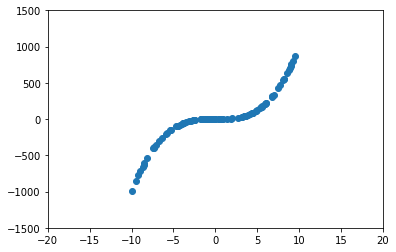

In [73]:
plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_0, train_labels_0_pre)
plt.show()

In [74]:
order = np.argsort(np.random.random(train_labels_0_pre.shape))

pre_train_data_0 = np.array(train_data_0[order]).reshape(data_points, 1)
train_labels_0 = np.array(train_labels_0_pre[order]).reshape(data_points, 1)

mean = pre_train_data_0.mean(axis=0)
std = pre_train_data_0.std(axis=0)

post_train_data_0 = (pre_train_data_0 - mean) / std

In [55]:
space = {
    'choice': hp.choice('layers_number', [{'layers': 'two'}, 
                                          {'layers': 'three',     
                                           'units_3': hp.choice('units_3', [25, 64, 128]),
                                            'units_3_activation': 
                                               hp.choice('units_3_activation', 
                                                         [tf.keras.activations.relu, 
                                                         tf.keras.activations.sigmoid, 
                                                         tf.keras.activations.selu]),
                                           'dropout_3': hp.choice('dropout_3', np.linspace(0.1, 0.3, 3, dtype=float))
                                          }]),
    'units_1': hp.choice('units_1', [25, 64, 128]),
    'units_1_activation': hp.choice('units_1_activation', [tf.keras.activations.relu, 
                                                         tf.keras.activations.sigmoid, 
                                                         tf.keras.activations.selu]),
    'dropout_1': hp.choice('dropout_1', np.linspace(0.1, 0.3, 3, dtype=float)),
    'units_2': hp.choice('units_2', [25, 64, 128]),
    'units_2_activation': hp.choice('units_2_activation', [tf.keras.activations.relu, 
                                                         tf.keras.activations.sigmoid, 
                                                         tf.keras.activations.selu]),
    'optimizer': hp.choice('optimizer', [tf.train.RMSPropOptimizer(learning_rate=0.5),
                                        tf.train.AdamOptimizer(1e-4)]) 
}

In [56]:
def build_model_hopt(params):
    EPOCHS = 800
    model = keras.Sequential()
    model.add(keras.layers.Dense(params['units_1'], activation=params['units_1_activation'],
                       input_shape=(post_train_data_0.shape[1],)))
    model.add(keras.layers.Dropout(params['dropout_1']))
    model.add(keras.layers.Dense(params['units_2'], activation=params['units_2_activation']))
        
    if params['choice']['layers'] == 'three':
        model.add(keras.layers.Dense(params['choice']['units_3'], init = "glorot_normal")) 
        model.add(keras.layers.Dropout(params['choice']['dropout_3']))
    
    model.add(keras.layers.Dense(1))

    model.compile(loss='mse',
                optimizer=params['optimizer'],
                metrics=['mae'])
    

    model.fit(post_train_data_0, train_labels_0, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)
    
    predicted_0 = model.predict(train_data_0).reshape(data_points, 1)
    
    acc = np.sum(np.abs(predicted_0 - train_data_0))

    return {'loss': -acc, 'status': STATUS_OK}

In [58]:
trials = Trials()
best = fmin(build_model_hopt, space, algo=tpe.suggest, max_evals = 5, trials=trials)
print(best)

/home/amir/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="glorot_normal")`
  # Remove the CWD from sys.path while we load stuff.


Train on 80 samples, validate on 20 samples
Epoch 1/800
80/80 [==============================] - 3s 35ms/step - loss: 171672.8062 - mean_absolute_error: 289.5262 - val_loss: 180360.3906 - val_mean_absolute_error: 305.4505
Epoch 2/800
80/80 [==============================] - 0s 168us/step - loss: 171543.2000 - mean_absolute_error: 289.5187 - val_loss: 180265.0469 - val_mean_absolute_error: 305.4196
Epoch 3/800
80/80 [==============================] - 0s 187us/step - loss: 171432.2000 - mean_absolute_error: 289.4171 - val_loss: 180157.0938 - val_mean_absolute_error: 305.4041
Epoch 4/800
80/80 [==============================] - 0s 174us/step - loss: 171325.4750 - mean_absolute_error: 289.3888 - val_loss: 180044.0156 - val_mean_absolute_error: 305.4468
Epoch 5/800
80/80 [==============================] - 0s 205us/step - loss: 171170.8062 - mean_absolute_error: 289.3015 - val_loss: 179927.3438 - val_mean_absolute_error: 305.4637
Epoch 6/800
80/80 [==============================] - 0s 178us/

80/80 [==============================] - 0s 179us/step - loss: 160294.3500 - mean_absolute_error: 280.7025 - val_loss: 168030.6094 - val_mean_absolute_error: 299.5520
Epoch 47/800
80/80 [==============================] - 0s 181us/step - loss: 160427.2063 - mean_absolute_error: 280.5092 - val_loss: 167469.6719 - val_mean_absolute_error: 299.1639
Epoch 48/800
80/80 [==============================] - 0s 185us/step - loss: 160011.3969 - mean_absolute_error: 280.0038 - val_loss: 166900.4688 - val_mean_absolute_error: 298.7540
Epoch 49/800
80/80 [==============================] - 0s 221us/step - loss: 159001.2375 - mean_absolute_error: 279.1914 - val_loss: 166319.0781 - val_mean_absolute_error: 298.3352
Epoch 50/800
80/80 [==============================] - 0s 220us/step - loss: 158604.4250 - mean_absolute_error: 279.0419 - val_loss: 165711.5938 - val_mean_absolute_error: 297.9390
Epoch 51/800
80/80 [==============================] - 0s 172us/step - loss: 158549.3969 - mean_absolute_error: 27

80/80 [==============================] - 0s 181us/step - loss: 127181.8344 - mean_absolute_error: 244.9198 - val_loss: 131984.1875 - val_mean_absolute_error: 267.1890
Epoch 92/800
80/80 [==============================] - 0s 174us/step - loss: 128105.2031 - mean_absolute_error: 245.8494 - val_loss: 131051.1719 - val_mean_absolute_error: 266.1569
Epoch 93/800
80/80 [==============================] - 0s 175us/step - loss: 127107.2047 - mean_absolute_error: 245.6932 - val_loss: 130120.7266 - val_mean_absolute_error: 265.1273
Epoch 94/800
80/80 [==============================] - 0s 186us/step - loss: 125590.5656 - mean_absolute_error: 244.2736 - val_loss: 129210.8594 - val_mean_absolute_error: 264.1010
Epoch 95/800
80/80 [==============================] - 0s 173us/step - loss: 124459.0109 - mean_absolute_error: 241.5913 - val_loss: 128304.5156 - val_mean_absolute_error: 263.0601
Epoch 96/800
80/80 [==============================] - 0s 184us/step - loss: 124458.9719 - mean_absolute_error: 24

80/80 [==============================] - 0s 151us/step - loss: 96198.6078 - mean_absolute_error: 207.6545 - val_loss: 95467.8672 - val_mean_absolute_error: 222.1037
Epoch 137/800
80/80 [==============================] - 0s 154us/step - loss: 96222.6711 - mean_absolute_error: 206.8076 - val_loss: 94810.1875 - val_mean_absolute_error: 221.3435
Epoch 138/800
80/80 [==============================] - 0s 173us/step - loss: 96157.4719 - mean_absolute_error: 205.9181 - val_loss: 94154.0000 - val_mean_absolute_error: 220.5847
Epoch 139/800
80/80 [==============================] - 0s 178us/step - loss: 93428.3625 - mean_absolute_error: 204.4580 - val_loss: 93512.3906 - val_mean_absolute_error: 219.8363
Epoch 140/800
80/80 [==============================] - 0s 161us/step - loss: 94642.9797 - mean_absolute_error: 204.8917 - val_loss: 92867.1016 - val_mean_absolute_error: 219.0859
Epoch 141/800
80/80 [==============================] - 0s 159us/step - loss: 92916.2250 - mean_absolute_error: 205.1904

Epoch 182/800
80/80 [==============================] - 0s 172us/step - loss: 76453.3320 - mean_absolute_error: 185.8164 - val_loss: 70794.7188 - val_mean_absolute_error: 199.3005
Epoch 183/800
80/80 [==============================] - 0s 163us/step - loss: 74741.8531 - mean_absolute_error: 181.7148 - val_loss: 70402.3594 - val_mean_absolute_error: 198.9382
Epoch 184/800
80/80 [==============================] - 0s 161us/step - loss: 74949.0297 - mean_absolute_error: 182.6645 - val_loss: 69999.5547 - val_mean_absolute_error: 198.5655
Epoch 185/800
80/80 [==============================] - 0s 178us/step - loss: 71746.4062 - mean_absolute_error: 179.6005 - val_loss: 69608.1172 - val_mean_absolute_error: 198.2008
Epoch 186/800
80/80 [==============================] - 0s 173us/step - loss: 74322.0398 - mean_absolute_error: 185.1152 - val_loss: 69229.7969 - val_mean_absolute_error: 197.9018
Epoch 187/800
80/80 [==============================] - 0s 161us/step - loss: 72912.4703 - mean_absolute_e

Epoch 228/800
80/80 [==============================] - 0s 164us/step - loss: 64237.4828 - mean_absolute_error: 171.9448 - val_loss: 56844.6484 - val_mean_absolute_error: 187.2382
Epoch 229/800
80/80 [==============================] - 0s 176us/step - loss: 63871.5422 - mean_absolute_error: 175.0902 - val_loss: 56618.7891 - val_mean_absolute_error: 187.0047
Epoch 230/800
80/80 [==============================] - 0s 168us/step - loss: 64803.4766 - mean_absolute_error: 173.8073 - val_loss: 56394.5547 - val_mean_absolute_error: 186.7682
Epoch 231/800
80/80 [==============================] - 0s 168us/step - loss: 62706.2969 - mean_absolute_error: 171.2145 - val_loss: 56169.7617 - val_mean_absolute_error: 186.5338
Epoch 232/800
80/80 [==============================] - 0s 201us/step - loss: 62158.1125 - mean_absolute_error: 171.9138 - val_loss: 55950.7500 - val_mean_absolute_error: 186.2975
Epoch 233/800
80/80 [==============================] - 0s 176us/step - loss: 62871.8141 - mean_absolute_e

Epoch 274/800
80/80 [==============================] - 0s 158us/step - loss: 55447.0367 - mean_absolute_error: 166.3092 - val_loss: 49021.8008 - val_mean_absolute_error: 177.3109
Epoch 275/800
80/80 [==============================] - 0s 178us/step - loss: 56861.9188 - mean_absolute_error: 168.3855 - val_loss: 48873.5938 - val_mean_absolute_error: 177.0926
Epoch 276/800
80/80 [==============================] - 0s 170us/step - loss: 56424.9863 - mean_absolute_error: 169.3603 - val_loss: 48740.6836 - val_mean_absolute_error: 176.8913
Epoch 277/800
80/80 [==============================] - 0s 163us/step - loss: 55953.2367 - mean_absolute_error: 165.9459 - val_loss: 48614.3984 - val_mean_absolute_error: 176.6914
Epoch 278/800
80/80 [==============================] - 0s 160us/step - loss: 56335.7797 - mean_absolute_error: 168.7425 - val_loss: 48478.4883 - val_mean_absolute_error: 176.4910
Epoch 279/800
80/80 [==============================] - 0s 150us/step - loss: 57054.8906 - mean_absolute_e

Epoch 320/800
80/80 [==============================] - 0s 173us/step - loss: 54291.0922 - mean_absolute_error: 168.2088 - val_loss: 44306.5781 - val_mean_absolute_error: 168.4229
Epoch 321/800
80/80 [==============================] - 0s 180us/step - loss: 55360.1023 - mean_absolute_error: 170.2605 - val_loss: 44228.6875 - val_mean_absolute_error: 168.2478
Epoch 322/800
80/80 [==============================] - 0s 159us/step - loss: 53147.8543 - mean_absolute_error: 169.4375 - val_loss: 44150.6719 - val_mean_absolute_error: 168.0727
Epoch 323/800
80/80 [==============================] - 0s 167us/step - loss: 53805.8617 - mean_absolute_error: 166.0554 - val_loss: 44071.5781 - val_mean_absolute_error: 167.9052
Epoch 324/800
80/80 [==============================] - 0s 170us/step - loss: 55683.6188 - mean_absolute_error: 170.4257 - val_loss: 44004.0156 - val_mean_absolute_error: 167.7428
Epoch 325/800
80/80 [==============================] - 0s 162us/step - loss: 53486.0891 - mean_absolute_e

Epoch 366/800
80/80 [==============================] - 0s 176us/step - loss: 52984.2234 - mean_absolute_error: 170.7033 - val_loss: 41410.3008 - val_mean_absolute_error: 161.0580
Epoch 367/800
80/80 [==============================] - 0s 152us/step - loss: 49692.1125 - mean_absolute_error: 164.9698 - val_loss: 41359.4375 - val_mean_absolute_error: 160.9152
Epoch 368/800
80/80 [==============================] - 0s 162us/step - loss: 52156.4016 - mean_absolute_error: 171.5548 - val_loss: 41298.3984 - val_mean_absolute_error: 160.7640
Epoch 369/800
80/80 [==============================] - 0s 175us/step - loss: 49936.4734 - mean_absolute_error: 163.3768 - val_loss: 41244.8477 - val_mean_absolute_error: 160.6125
Epoch 370/800
80/80 [==============================] - 0s 175us/step - loss: 50639.5031 - mean_absolute_error: 166.1846 - val_loss: 41191.0273 - val_mean_absolute_error: 160.4631
Epoch 371/800
80/80 [==============================] - 0s 175us/step - loss: 50922.9023 - mean_absolute_e

Epoch 412/800
80/80 [==============================] - 0s 166us/step - loss: 48696.9277 - mean_absolute_error: 163.6634 - val_loss: 39318.3203 - val_mean_absolute_error: 156.1342
Epoch 413/800
80/80 [==============================] - 0s 168us/step - loss: 48199.1758 - mean_absolute_error: 164.8230 - val_loss: 39273.3320 - val_mean_absolute_error: 156.0434
Epoch 414/800
80/80 [==============================] - 0s 159us/step - loss: 46384.7184 - mean_absolute_error: 162.2770 - val_loss: 39232.4453 - val_mean_absolute_error: 155.9491
Epoch 415/800
80/80 [==============================] - 0s 180us/step - loss: 48164.6516 - mean_absolute_error: 160.2845 - val_loss: 39184.9258 - val_mean_absolute_error: 155.8528
Epoch 416/800
80/80 [==============================] - 0s 179us/step - loss: 50241.7102 - mean_absolute_error: 170.8315 - val_loss: 39143.8438 - val_mean_absolute_error: 155.7587
Epoch 417/800
80/80 [==============================] - 0s 204us/step - loss: 49389.7297 - mean_absolute_e

Epoch 458/800
80/80 [==============================] - 0s 173us/step - loss: 48469.1828 - mean_absolute_error: 165.9404 - val_loss: 37466.1016 - val_mean_absolute_error: 152.4558
Epoch 459/800
80/80 [==============================] - 0s 157us/step - loss: 48494.4711 - mean_absolute_error: 163.8035 - val_loss: 37427.1406 - val_mean_absolute_error: 152.3956
Epoch 460/800
80/80 [==============================] - 0s 163us/step - loss: 48196.9883 - mean_absolute_error: 165.6145 - val_loss: 37389.9688 - val_mean_absolute_error: 152.3326
Epoch 461/800
80/80 [==============================] - 0s 156us/step - loss: 46587.2953 - mean_absolute_error: 160.8105 - val_loss: 37352.8086 - val_mean_absolute_error: 152.2708
Epoch 462/800
80/80 [==============================] - 0s 158us/step - loss: 46487.5156 - mean_absolute_error: 163.4397 - val_loss: 37305.6562 - val_mean_absolute_error: 152.2053
Epoch 463/800
80/80 [==============================] - 0s 162us/step - loss: 46357.5969 - mean_absolute_e

Epoch 504/800
80/80 [==============================] - 0s 190us/step - loss: 45907.6797 - mean_absolute_error: 162.8951 - val_loss: 36029.0195 - val_mean_absolute_error: 149.9672
Epoch 505/800
80/80 [==============================] - 0s 168us/step - loss: 46746.4797 - mean_absolute_error: 165.9559 - val_loss: 36001.2891 - val_mean_absolute_error: 149.9398
Epoch 506/800
80/80 [==============================] - 0s 219us/step - loss: 44094.4094 - mean_absolute_error: 161.1889 - val_loss: 35978.4883 - val_mean_absolute_error: 149.9043
Epoch 507/800
80/80 [==============================] - 0s 163us/step - loss: 45599.0547 - mean_absolute_error: 160.3005 - val_loss: 35950.5078 - val_mean_absolute_error: 149.8847
Epoch 508/800
80/80 [==============================] - 0s 180us/step - loss: 45459.5687 - mean_absolute_error: 161.7230 - val_loss: 35912.8008 - val_mean_absolute_error: 149.8527
Epoch 509/800
80/80 [==============================] - 0s 182us/step - loss: 47101.8594 - mean_absolute_e

Epoch 550/800
80/80 [==============================] - 0s 172us/step - loss: 43880.9125 - mean_absolute_error: 158.5187 - val_loss: 34640.9883 - val_mean_absolute_error: 148.2443
Epoch 551/800
80/80 [==============================] - 0s 195us/step - loss: 46052.6840 - mean_absolute_error: 159.3251 - val_loss: 34616.9492 - val_mean_absolute_error: 148.2147
Epoch 552/800
80/80 [==============================] - 0s 215us/step - loss: 44646.8312 - mean_absolute_error: 161.9581 - val_loss: 34582.1055 - val_mean_absolute_error: 148.1695
Epoch 553/800
80/80 [==============================] - 0s 203us/step - loss: 44826.1703 - mean_absolute_error: 161.7812 - val_loss: 34553.6875 - val_mean_absolute_error: 148.1288
Epoch 554/800
80/80 [==============================] - 0s 211us/step - loss: 41709.6688 - mean_absolute_error: 152.9898 - val_loss: 34526.9492 - val_mean_absolute_error: 148.0953
Epoch 555/800
80/80 [==============================] - 0s 153us/step - loss: 44200.5090 - mean_absolute_e

Epoch 596/800
80/80 [==============================] - 0s 174us/step - loss: 42452.7938 - mean_absolute_error: 155.8120 - val_loss: 33585.8906 - val_mean_absolute_error: 146.6890
Epoch 597/800
80/80 [==============================] - 0s 193us/step - loss: 41002.4070 - mean_absolute_error: 155.8616 - val_loss: 33575.9883 - val_mean_absolute_error: 146.6677
Epoch 598/800
80/80 [==============================] - 0s 174us/step - loss: 44563.7891 - mean_absolute_error: 162.2090 - val_loss: 33565.0117 - val_mean_absolute_error: 146.6362
Epoch 599/800
80/80 [==============================] - 0s 168us/step - loss: 41892.8187 - mean_absolute_error: 159.2715 - val_loss: 33545.7188 - val_mean_absolute_error: 146.6057
Epoch 600/800
80/80 [==============================] - 0s 166us/step - loss: 45400.6172 - mean_absolute_error: 164.3516 - val_loss: 33530.6016 - val_mean_absolute_error: 146.5821
Epoch 601/800
80/80 [==============================] - 0s 162us/step - loss: 44551.0145 - mean_absolute_e

Epoch 642/800
80/80 [==============================] - 0s 222us/step - loss: 41510.7008 - mean_absolute_error: 153.4985 - val_loss: 32582.2812 - val_mean_absolute_error: 144.9238
Epoch 643/800
80/80 [==============================] - 0s 169us/step - loss: 45741.5211 - mean_absolute_error: 162.3788 - val_loss: 32565.2969 - val_mean_absolute_error: 144.8908
Epoch 644/800
80/80 [==============================] - 0s 207us/step - loss: 44051.5305 - mean_absolute_error: 157.7446 - val_loss: 32544.2344 - val_mean_absolute_error: 144.8573
Epoch 645/800
80/80 [==============================] - 0s 175us/step - loss: 41695.4641 - mean_absolute_error: 156.6830 - val_loss: 32525.9941 - val_mean_absolute_error: 144.8226
Epoch 646/800
80/80 [==============================] - 0s 197us/step - loss: 44446.2008 - mean_absolute_error: 164.0352 - val_loss: 32509.6367 - val_mean_absolute_error: 144.7992
Epoch 647/800
80/80 [==============================] - 0s 168us/step - loss: 42190.7820 - mean_absolute_e

80/80 [==============================] - 0s 164us/step - loss: 40862.6180 - mean_absolute_error: 155.3980 - val_loss: 31828.5469 - val_mean_absolute_error: 143.7552
Epoch 688/800
80/80 [==============================] - 0s 186us/step - loss: 41068.9078 - mean_absolute_error: 154.2128 - val_loss: 31814.6250 - val_mean_absolute_error: 143.7261
Epoch 689/800
80/80 [==============================] - 0s 188us/step - loss: 43056.1805 - mean_absolute_error: 164.1433 - val_loss: 31802.9805 - val_mean_absolute_error: 143.6947
Epoch 690/800
80/80 [==============================] - 0s 153us/step - loss: 42604.8516 - mean_absolute_error: 159.3453 - val_loss: 31790.3125 - val_mean_absolute_error: 143.6598
Epoch 691/800
80/80 [==============================] - 0s 162us/step - loss: 39258.7406 - mean_absolute_error: 154.9446 - val_loss: 31764.9531 - val_mean_absolute_error: 143.6203
Epoch 692/800
80/80 [==============================] - 0s 159us/step - loss: 43194.6430 - mean_absolute_error: 159.8756

Epoch 733/800
80/80 [==============================] - 0s 179us/step - loss: 39894.0328 - mean_absolute_error: 158.3503 - val_loss: 30883.0664 - val_mean_absolute_error: 142.2558
Epoch 734/800
80/80 [==============================] - 0s 162us/step - loss: 42379.3383 - mean_absolute_error: 157.8239 - val_loss: 30859.1660 - val_mean_absolute_error: 142.2066
Epoch 735/800
80/80 [==============================] - 0s 157us/step - loss: 38432.1555 - mean_absolute_error: 150.1637 - val_loss: 30835.4941 - val_mean_absolute_error: 142.1642
Epoch 736/800
80/80 [==============================] - 0s 168us/step - loss: 42850.4445 - mean_absolute_error: 156.9897 - val_loss: 30830.6758 - val_mean_absolute_error: 142.1529
Epoch 737/800
80/80 [==============================] - 0s 177us/step - loss: 42483.6406 - mean_absolute_error: 158.3275 - val_loss: 30826.4316 - val_mean_absolute_error: 142.1489
Epoch 738/800
80/80 [==============================] - 0s 154us/step - loss: 41086.7633 - mean_absolute_e

Epoch 779/800
80/80 [==============================] - 0s 156us/step - loss: 38988.0883 - mean_absolute_error: 152.2969 - val_loss: 30327.0215 - val_mean_absolute_error: 141.1433
Epoch 780/800
80/80 [==============================] - 0s 176us/step - loss: 39328.1793 - mean_absolute_error: 153.1205 - val_loss: 30333.7812 - val_mean_absolute_error: 141.1569
Epoch 781/800
80/80 [==============================] - 0s 170us/step - loss: 38217.1367 - mean_absolute_error: 147.7053 - val_loss: 30337.3320 - val_mean_absolute_error: 141.1590
Epoch 782/800
80/80 [==============================] - 0s 161us/step - loss: 38555.4719 - mean_absolute_error: 152.2755 - val_loss: 30329.7129 - val_mean_absolute_error: 141.1548
Epoch 783/800
80/80 [==============================] - 0s 162us/step - loss: 38849.8381 - mean_absolute_error: 150.9951 - val_loss: 30309.2305 - val_mean_absolute_error: 141.1358
Epoch 784/800
80/80 [==============================] - 0s 188us/step - loss: 41211.6719 - mean_absolute_e

80/80 [==============================] - 0s 190us/step - loss: 159743.4656 - mean_absolute_error: 275.3108 - val_loss: 167456.7188 - val_mean_absolute_error: 290.5385
Epoch 25/800
80/80 [==============================] - 0s 187us/step - loss: 159290.9375 - mean_absolute_error: 274.7286 - val_loss: 166898.0156 - val_mean_absolute_error: 289.8824
Epoch 26/800
80/80 [==============================] - 0s 182us/step - loss: 158841.7484 - mean_absolute_error: 274.0638 - val_loss: 166337.6875 - val_mean_absolute_error: 289.2228
Epoch 27/800
80/80 [==============================] - 0s 170us/step - loss: 158308.2906 - mean_absolute_error: 273.4935 - val_loss: 165787.7031 - val_mean_absolute_error: 288.5733
Epoch 28/800
80/80 [==============================] - 0s 168us/step - loss: 157642.0500 - mean_absolute_error: 272.8282 - val_loss: 165234.8125 - val_mean_absolute_error: 287.9185
Epoch 29/800
80/80 [==============================] - 0s 153us/step - loss: 157208.1031 - mean_absolute_error: 27

80/80 [==============================] - 0s 195us/step - loss: 136670.3406 - mean_absolute_error: 248.1881 - val_loss: 143112.2500 - val_mean_absolute_error: 264.4807
Epoch 70/800
80/80 [==============================] - 0s 213us/step - loss: 136216.5203 - mean_absolute_error: 247.4191 - val_loss: 142570.3438 - val_mean_absolute_error: 263.9371
Epoch 71/800
80/80 [==============================] - 0s 210us/step - loss: 135871.0906 - mean_absolute_error: 247.0716 - val_loss: 142042.5469 - val_mean_absolute_error: 263.4052
Epoch 72/800
80/80 [==============================] - 0s 181us/step - loss: 135543.9031 - mean_absolute_error: 246.5478 - val_loss: 141505.9062 - val_mean_absolute_error: 262.8715
Epoch 73/800
80/80 [==============================] - 0s 189us/step - loss: 135090.7250 - mean_absolute_error: 246.1321 - val_loss: 140961.8438 - val_mean_absolute_error: 262.3789
Epoch 74/800
80/80 [==============================] - 0s 177us/step - loss: 134396.9383 - mean_absolute_error: 24

80/80 [==============================] - 0s 194us/step - loss: 115000.2500 - mean_absolute_error: 225.0519 - val_loss: 119542.6875 - val_mean_absolute_error: 241.9071
Epoch 114/800
80/80 [==============================] - 0s 185us/step - loss: 114567.5875 - mean_absolute_error: 224.8260 - val_loss: 119013.0000 - val_mean_absolute_error: 241.3690
Epoch 115/800
80/80 [==============================] - 0s 156us/step - loss: 113865.0781 - mean_absolute_error: 224.1468 - val_loss: 118477.5000 - val_mean_absolute_error: 240.8233
Epoch 116/800
80/80 [==============================] - 0s 185us/step - loss: 113325.5988 - mean_absolute_error: 223.2376 - val_loss: 117943.1641 - val_mean_absolute_error: 240.3400
Epoch 117/800
80/80 [==============================] - 0s 152us/step - loss: 112844.4672 - mean_absolute_error: 222.8744 - val_loss: 117428.0156 - val_mean_absolute_error: 239.8769
Epoch 118/800
80/80 [==============================] - 0s 162us/step - loss: 112064.2906 - mean_absolute_erro

80/80 [==============================] - 0s 169us/step - loss: 93490.5938 - mean_absolute_error: 201.6953 - val_loss: 96172.1406 - val_mean_absolute_error: 219.3853
Epoch 159/800
80/80 [==============================] - 0s 131us/step - loss: 92955.4297 - mean_absolute_error: 200.9114 - val_loss: 95666.4531 - val_mean_absolute_error: 218.8528
Epoch 160/800
80/80 [==============================] - 0s 164us/step - loss: 92275.8000 - mean_absolute_error: 200.0924 - val_loss: 95162.7344 - val_mean_absolute_error: 218.3171
Epoch 161/800
80/80 [==============================] - 0s 146us/step - loss: 91713.7203 - mean_absolute_error: 199.5782 - val_loss: 94671.8359 - val_mean_absolute_error: 217.7929
Epoch 162/800
80/80 [==============================] - 0s 147us/step - loss: 90789.4703 - mean_absolute_error: 198.3380 - val_loss: 94182.1328 - val_mean_absolute_error: 217.2695
Epoch 163/800
80/80 [==============================] - 0s 164us/step - loss: 90736.2859 - mean_absolute_error: 198.4908

Epoch 204/800
80/80 [==============================] - 0s 168us/step - loss: 74174.8313 - mean_absolute_error: 178.2596 - val_loss: 75106.6328 - val_mean_absolute_error: 196.0399
Epoch 205/800
80/80 [==============================] - 0s 138us/step - loss: 73270.1687 - mean_absolute_error: 178.1717 - val_loss: 74671.4141 - val_mean_absolute_error: 195.5772
Epoch 206/800
80/80 [==============================] - 0s 151us/step - loss: 73148.3609 - mean_absolute_error: 177.3314 - val_loss: 74256.0781 - val_mean_absolute_error: 195.1339
Epoch 207/800
80/80 [==============================] - 0s 159us/step - loss: 72306.1547 - mean_absolute_error: 176.5490 - val_loss: 73832.7969 - val_mean_absolute_error: 194.6800
Epoch 208/800
80/80 [==============================] - 0s 142us/step - loss: 72040.9297 - mean_absolute_error: 176.3214 - val_loss: 73414.6562 - val_mean_absolute_error: 194.2294
Epoch 209/800
80/80 [==============================] - 0s 151us/step - loss: 72108.9781 - mean_absolute_e

Epoch 250/800
80/80 [==============================] - 0s 162us/step - loss: 59267.2938 - mean_absolute_error: 163.7198 - val_loss: 58370.1133 - val_mean_absolute_error: 176.2982
Epoch 251/800
80/80 [==============================] - 0s 166us/step - loss: 58934.3656 - mean_absolute_error: 163.4138 - val_loss: 58074.2930 - val_mean_absolute_error: 175.9960
Epoch 252/800
80/80 [==============================] - 0s 142us/step - loss: 57295.3828 - mean_absolute_error: 162.0661 - val_loss: 57786.5859 - val_mean_absolute_error: 175.7012
Epoch 253/800
80/80 [==============================] - 0s 151us/step - loss: 57608.9453 - mean_absolute_error: 162.4736 - val_loss: 57495.6133 - val_mean_absolute_error: 175.3976
Epoch 254/800
80/80 [==============================] - 0s 172us/step - loss: 57461.2750 - mean_absolute_error: 162.9394 - val_loss: 57206.8359 - val_mean_absolute_error: 175.0891
Epoch 255/800
80/80 [==============================] - 0s 155us/step - loss: 58493.4402 - mean_absolute_e

Epoch 296/800
80/80 [==============================] - 0s 158us/step - loss: 48302.4562 - mean_absolute_error: 155.5015 - val_loss: 47041.7070 - val_mean_absolute_error: 162.8963
Epoch 297/800
80/80 [==============================] - 0s 159us/step - loss: 49078.0906 - mean_absolute_error: 156.8176 - val_loss: 46832.3086 - val_mean_absolute_error: 162.6020
Epoch 298/800
80/80 [==============================] - 0s 148us/step - loss: 48785.8234 - mean_absolute_error: 156.9564 - val_loss: 46626.9727 - val_mean_absolute_error: 162.3061
Epoch 299/800
80/80 [==============================] - 0s 149us/step - loss: 47236.8418 - mean_absolute_error: 155.5265 - val_loss: 46420.8398 - val_mean_absolute_error: 162.0146
Epoch 300/800
80/80 [==============================] - 0s 168us/step - loss: 47927.1625 - mean_absolute_error: 156.4379 - val_loss: 46226.8672 - val_mean_absolute_error: 161.7363
Epoch 301/800
80/80 [==============================] - 0s 158us/step - loss: 48370.3961 - mean_absolute_e

Epoch 342/800
80/80 [==============================] - 0s 147us/step - loss: 41332.9379 - mean_absolute_error: 154.3521 - val_loss: 39446.8359 - val_mean_absolute_error: 153.9691
Epoch 343/800
80/80 [==============================] - 0s 168us/step - loss: 41276.0484 - mean_absolute_error: 154.7945 - val_loss: 39324.5547 - val_mean_absolute_error: 153.8715
Epoch 344/800
80/80 [==============================] - 0s 152us/step - loss: 41627.2062 - mean_absolute_error: 155.1592 - val_loss: 39201.9844 - val_mean_absolute_error: 153.7732
Epoch 345/800
80/80 [==============================] - 0s 146us/step - loss: 41641.5523 - mean_absolute_error: 155.0387 - val_loss: 39077.3477 - val_mean_absolute_error: 153.7041
Epoch 346/800
80/80 [==============================] - 0s 152us/step - loss: 40936.5641 - mean_absolute_error: 155.3032 - val_loss: 38949.1953 - val_mean_absolute_error: 153.6641
Epoch 347/800
80/80 [==============================] - 0s 143us/step - loss: 41709.3898 - mean_absolute_e

80/80 [==============================] - 0s 151us/step - loss: 37842.9500 - mean_absolute_error: 154.8551 - val_loss: 34993.6328 - val_mean_absolute_error: 153.2009
Epoch 388/800
80/80 [==============================] - 0s 156us/step - loss: 38005.0578 - mean_absolute_error: 156.2782 - val_loss: 34921.6328 - val_mean_absolute_error: 153.1982
Epoch 389/800
80/80 [==============================] - 0s 167us/step - loss: 37831.7250 - mean_absolute_error: 156.7185 - val_loss: 34852.4883 - val_mean_absolute_error: 153.2033
Epoch 390/800
80/80 [==============================] - 0s 133us/step - loss: 37984.7184 - mean_absolute_error: 156.4584 - val_loss: 34779.6016 - val_mean_absolute_error: 153.2053
Epoch 391/800
80/80 [==============================] - 0s 147us/step - loss: 38192.1695 - mean_absolute_error: 156.6880 - val_loss: 34709.0938 - val_mean_absolute_error: 153.1996
Epoch 392/800
80/80 [==============================] - 0s 147us/step - loss: 38668.4031 - mean_absolute_error: 158.9907

Epoch 433/800
80/80 [==============================] - 0s 168us/step - loss: 36178.0187 - mean_absolute_error: 159.1163 - val_loss: 32590.1934 - val_mean_absolute_error: 154.2286
Epoch 434/800
80/80 [==============================] - 0s 186us/step - loss: 37443.1410 - mean_absolute_error: 161.9837 - val_loss: 32552.4473 - val_mean_absolute_error: 154.2602
Epoch 435/800
80/80 [==============================] - 0s 147us/step - loss: 35858.6312 - mean_absolute_error: 158.3463 - val_loss: 32515.0508 - val_mean_absolute_error: 154.2811
Epoch 436/800
80/80 [==============================] - 0s 198us/step - loss: 36202.4609 - mean_absolute_error: 160.4425 - val_loss: 32481.6445 - val_mean_absolute_error: 154.3192
Epoch 437/800
80/80 [==============================] - 0s 152us/step - loss: 35169.4539 - mean_absolute_error: 158.3552 - val_loss: 32447.2871 - val_mean_absolute_error: 154.3491
Epoch 438/800
80/80 [==============================] - 0s 153us/step - loss: 36314.6836 - mean_absolute_e

Epoch 479/800
80/80 [==============================] - 0s 169us/step - loss: 35182.3187 - mean_absolute_error: 161.1316 - val_loss: 31281.3008 - val_mean_absolute_error: 155.4712
Epoch 480/800
80/80 [==============================] - 0s 150us/step - loss: 34652.5723 - mean_absolute_error: 160.1539 - val_loss: 31260.6035 - val_mean_absolute_error: 155.4868
Epoch 481/800
80/80 [==============================] - 0s 149us/step - loss: 33957.2922 - mean_absolute_error: 159.1851 - val_loss: 31240.5938 - val_mean_absolute_error: 155.5021
Epoch 482/800
80/80 [==============================] - 0s 144us/step - loss: 34667.4797 - mean_absolute_error: 160.5328 - val_loss: 31220.6367 - val_mean_absolute_error: 155.5032
Epoch 483/800
80/80 [==============================] - 0s 164us/step - loss: 34550.4305 - mean_absolute_error: 160.3066 - val_loss: 31202.7285 - val_mean_absolute_error: 155.5121
Epoch 484/800
80/80 [==============================] - 0s 162us/step - loss: 34954.9492 - mean_absolute_e

80/80 [==============================] - 0s 161us/step - loss: 33682.2949 - mean_absolute_error: 160.7953 - val_loss: 30492.3027 - val_mean_absolute_error: 155.4696
Epoch 525/800
80/80 [==============================] - 0s 167us/step - loss: 35335.8563 - mean_absolute_error: 163.8799 - val_loss: 30477.6836 - val_mean_absolute_error: 155.4615
Epoch 526/800
80/80 [==============================] - 0s 165us/step - loss: 34880.1320 - mean_absolute_error: 163.5995 - val_loss: 30464.1250 - val_mean_absolute_error: 155.4552
Epoch 527/800
80/80 [==============================] - 0s 178us/step - loss: 35083.3328 - mean_absolute_error: 162.3007 - val_loss: 30451.1504 - val_mean_absolute_error: 155.4494
Epoch 528/800
80/80 [==============================] - 0s 156us/step - loss: 34651.3867 - mean_absolute_error: 162.2048 - val_loss: 30441.8965 - val_mean_absolute_error: 155.4442
Epoch 529/800
80/80 [==============================] - 0s 142us/step - loss: 35182.5777 - mean_absolute_error: 163.8029

Epoch 570/800
80/80 [==============================] - 0s 160us/step - loss: 33406.8336 - mean_absolute_error: 161.1158 - val_loss: 29995.8164 - val_mean_absolute_error: 155.3911
Epoch 571/800
80/80 [==============================] - 0s 158us/step - loss: 33654.9828 - mean_absolute_error: 162.8677 - val_loss: 29987.7402 - val_mean_absolute_error: 155.3900
Epoch 572/800
80/80 [==============================] - 0s 174us/step - loss: 34148.0977 - mean_absolute_error: 163.1058 - val_loss: 29979.5684 - val_mean_absolute_error: 155.3877
Epoch 573/800
80/80 [==============================] - 0s 153us/step - loss: 34004.3898 - mean_absolute_error: 162.2807 - val_loss: 29965.1504 - val_mean_absolute_error: 155.3761
Epoch 574/800
80/80 [==============================] - 0s 158us/step - loss: 33629.2977 - mean_absolute_error: 160.0503 - val_loss: 29952.0625 - val_mean_absolute_error: 155.3624
Epoch 575/800
80/80 [==============================] - 0s 191us/step - loss: 33659.1023 - mean_absolute_e

Epoch 616/800
80/80 [==============================] - 0s 168us/step - loss: 33642.8367 - mean_absolute_error: 162.4203 - val_loss: 29747.4570 - val_mean_absolute_error: 155.3164
Epoch 617/800
80/80 [==============================] - 0s 159us/step - loss: 34013.5117 - mean_absolute_error: 162.5670 - val_loss: 29743.3398 - val_mean_absolute_error: 155.3075
Epoch 618/800
80/80 [==============================] - 0s 182us/step - loss: 33135.6477 - mean_absolute_error: 163.1535 - val_loss: 29736.6934 - val_mean_absolute_error: 155.3002
Epoch 619/800
80/80 [==============================] - 0s 183us/step - loss: 33090.7852 - mean_absolute_error: 161.5828 - val_loss: 29728.2871 - val_mean_absolute_error: 155.2747
Epoch 620/800
80/80 [==============================] - 0s 198us/step - loss: 33515.0430 - mean_absolute_error: 162.8186 - val_loss: 29727.0195 - val_mean_absolute_error: 155.2788
Epoch 621/800
80/80 [==============================] - 0s 191us/step - loss: 33120.6781 - mean_absolute_e

Epoch 662/800
80/80 [==============================] - 0s 170us/step - loss: 33920.4980 - mean_absolute_error: 164.4191 - val_loss: 29556.8691 - val_mean_absolute_error: 155.1516
Epoch 663/800
80/80 [==============================] - 0s 175us/step - loss: 33630.6754 - mean_absolute_error: 162.4409 - val_loss: 29551.2773 - val_mean_absolute_error: 155.1329
Epoch 664/800
80/80 [==============================] - 0s 161us/step - loss: 33309.1543 - mean_absolute_error: 163.1519 - val_loss: 29546.7871 - val_mean_absolute_error: 155.1115
Epoch 665/800
80/80 [==============================] - 0s 144us/step - loss: 34628.7812 - mean_absolute_error: 165.0391 - val_loss: 29545.3398 - val_mean_absolute_error: 155.0975
Epoch 666/800
80/80 [==============================] - 0s 141us/step - loss: 32997.0320 - mean_absolute_error: 162.0181 - val_loss: 29543.7070 - val_mean_absolute_error: 155.0957
Epoch 667/800
80/80 [==============================] - 0s 149us/step - loss: 33195.2742 - mean_absolute_e

Epoch 708/800
80/80 [==============================] - 0s 169us/step - loss: 34571.1375 - mean_absolute_error: 164.2152 - val_loss: 29399.2305 - val_mean_absolute_error: 154.8770
Epoch 709/800
80/80 [==============================] - 0s 150us/step - loss: 33680.6836 - mean_absolute_error: 163.5990 - val_loss: 29389.2695 - val_mean_absolute_error: 154.8582
Epoch 710/800
80/80 [==============================] - 0s 165us/step - loss: 33244.0770 - mean_absolute_error: 162.4139 - val_loss: 29375.4785 - val_mean_absolute_error: 154.8283
Epoch 711/800
80/80 [==============================] - 0s 180us/step - loss: 32942.2766 - mean_absolute_error: 161.5420 - val_loss: 29363.9746 - val_mean_absolute_error: 154.7946
Epoch 712/800
80/80 [==============================] - 0s 152us/step - loss: 32668.0508 - mean_absolute_error: 161.1883 - val_loss: 29348.6836 - val_mean_absolute_error: 154.7448
Epoch 713/800
80/80 [==============================] - 0s 146us/step - loss: 32639.9344 - mean_absolute_e

Epoch 754/800
80/80 [==============================] - 0s 185us/step - loss: 32198.3125 - mean_absolute_error: 159.5099 - val_loss: 29208.6680 - val_mean_absolute_error: 154.3503
Epoch 755/800
80/80 [==============================] - 0s 189us/step - loss: 32889.4047 - mean_absolute_error: 161.8585 - val_loss: 29207.5684 - val_mean_absolute_error: 154.3595
Epoch 756/800
80/80 [==============================] - 0s 176us/step - loss: 33362.7016 - mean_absolute_error: 162.5852 - val_loss: 29203.7129 - val_mean_absolute_error: 154.3640
Epoch 757/800
80/80 [==============================] - 0s 159us/step - loss: 32115.8484 - mean_absolute_error: 159.8871 - val_loss: 29195.1562 - val_mean_absolute_error: 154.3344
Epoch 758/800
80/80 [==============================] - 0s 161us/step - loss: 33154.0105 - mean_absolute_error: 161.9910 - val_loss: 29183.4941 - val_mean_absolute_error: 154.2914
Epoch 759/800
80/80 [==============================] - 0s 159us/step - loss: 32676.8547 - mean_absolute_e

Epoch 800/800
80/80 [==============================] - 0s 174us/step - loss: 32330.6758 - mean_absolute_error: 160.6121 - val_loss: 28986.9531 - val_mean_absolute_error: 153.7361
Train on 80 samples, validate on 20 samples
Epoch 1/800
80/80 [==============================] - 3s 37ms/step - loss: 430865034.4750 - mean_absolute_error: 9378.4362 - val_loss: 16820004.0000 - val_mean_absolute_error: 3324.4214
Epoch 2/800
80/80 [==============================] - 0s 175us/step - loss: 10562619.9000 - mean_absolute_error: 2525.5421 - val_loss: 2761885.2500 - val_mean_absolute_error: 1409.8644
Epoch 3/800
80/80 [==============================] - 0s 195us/step - loss: 1793056.1750 - mean_absolute_error: 1054.9411 - val_loss: 476983.1875 - val_mean_absolute_error: 594.0750
Epoch 4/800
80/80 [==============================] - 0s 189us/step - loss: 402770.3625 - mean_absolute_error: 526.0449 - val_loss: 220114.7812 - val_mean_absolute_error: 410.8639
Epoch 5/800
80/80 [=============================

80/80 [==============================] - 0s 192us/step - loss: 83556.5531 - mean_absolute_error: 207.0800 - val_loss: 81025.3359 - val_mean_absolute_error: 225.5356
Epoch 46/800
80/80 [==============================] - 0s 198us/step - loss: 135575.0219 - mean_absolute_error: 309.4711 - val_loss: 42716.3672 - val_mean_absolute_error: 158.2746
Epoch 47/800
80/80 [==============================] - 0s 157us/step - loss: 46208.2648 - mean_absolute_error: 160.1125 - val_loss: 35754.5547 - val_mean_absolute_error: 142.1879
Epoch 48/800
80/80 [==============================] - 0s 166us/step - loss: 38296.0094 - mean_absolute_error: 137.0560 - val_loss: 152459.3750 - val_mean_absolute_error: 341.2835
Epoch 49/800
80/80 [==============================] - 0s 154us/step - loss: 106105.2805 - mean_absolute_error: 259.2235 - val_loss: 114272.3359 - val_mean_absolute_error: 243.0282
Epoch 50/800
80/80 [==============================] - 0s 148us/step - loss: 104553.1188 - mean_absolute_error: 220.2257

80/80 [==============================] - 0s 195us/step - loss: 47605.6617 - mean_absolute_error: 151.3553 - val_loss: 54184.5508 - val_mean_absolute_error: 195.4377
Epoch 92/800
80/80 [==============================] - 0s 189us/step - loss: 56681.3664 - mean_absolute_error: 174.8571 - val_loss: 26111.9668 - val_mean_absolute_error: 131.9296
Epoch 93/800
80/80 [==============================] - 0s 188us/step - loss: 29353.7078 - mean_absolute_error: 125.8852 - val_loss: 24358.0449 - val_mean_absolute_error: 134.5392
Epoch 94/800
80/80 [==============================] - 0s 182us/step - loss: 46740.3398 - mean_absolute_error: 152.7564 - val_loss: 32751.2188 - val_mean_absolute_error: 130.0274
Epoch 95/800
80/80 [==============================] - 0s 203us/step - loss: 31358.0609 - mean_absolute_error: 127.3536 - val_loss: 9527.1543 - val_mean_absolute_error: 77.1831
Epoch 96/800
80/80 [==============================] - 0s 212us/step - loss: 23509.3004 - mean_absolute_error: 110.3635 - val_

80/80 [==============================] - 0s 196us/step - loss: 49951.8094 - mean_absolute_error: 177.4571 - val_loss: 17445.9668 - val_mean_absolute_error: 110.5537
Epoch 138/800
80/80 [==============================] - 0s 164us/step - loss: 36463.0949 - mean_absolute_error: 138.2023 - val_loss: 23613.9961 - val_mean_absolute_error: 114.8419
Epoch 139/800
80/80 [==============================] - 0s 180us/step - loss: 32318.2578 - mean_absolute_error: 117.4108 - val_loss: 4977.0015 - val_mean_absolute_error: 48.0568
Epoch 140/800
80/80 [==============================] - 0s 181us/step - loss: 17734.3320 - mean_absolute_error: 104.2028 - val_loss: 38083.3594 - val_mean_absolute_error: 151.4752
Epoch 141/800
80/80 [==============================] - 0s 185us/step - loss: 30153.8244 - mean_absolute_error: 120.8740 - val_loss: 54029.8125 - val_mean_absolute_error: 177.9964
Epoch 142/800
80/80 [==============================] - 0s 218us/step - loss: 81056.8078 - mean_absolute_error: 215.0350 -

80/80 [==============================] - 0s 186us/step - loss: 22529.4973 - mean_absolute_error: 126.6089 - val_loss: 42198.5938 - val_mean_absolute_error: 167.3730
Epoch 184/800
80/80 [==============================] - 0s 185us/step - loss: 17355.6336 - mean_absolute_error: 110.5372 - val_loss: 11309.2031 - val_mean_absolute_error: 84.8460
Epoch 185/800
80/80 [==============================] - 0s 183us/step - loss: 30414.7738 - mean_absolute_error: 118.4074 - val_loss: 25218.7539 - val_mean_absolute_error: 139.0270
Epoch 186/800
80/80 [==============================] - 0s 159us/step - loss: 43625.4180 - mean_absolute_error: 133.3936 - val_loss: 13608.2080 - val_mean_absolute_error: 101.7591
Epoch 187/800
80/80 [==============================] - 0s 182us/step - loss: 20458.7771 - mean_absolute_error: 104.8122 - val_loss: 57513.3203 - val_mean_absolute_error: 190.7124
Epoch 188/800
80/80 [==============================] - 0s 179us/step - loss: 27630.9465 - mean_absolute_error: 113.5776 

80/80 [==============================] - 0s 151us/step - loss: 27973.5955 - mean_absolute_error: 104.3057 - val_loss: 14828.4863 - val_mean_absolute_error: 99.1786
Epoch 230/800
80/80 [==============================] - 0s 178us/step - loss: 13710.3637 - mean_absolute_error: 89.8282 - val_loss: 5339.0024 - val_mean_absolute_error: 60.0388
Epoch 231/800
80/80 [==============================] - 0s 173us/step - loss: 36512.3521 - mean_absolute_error: 112.8620 - val_loss: 31314.5410 - val_mean_absolute_error: 117.2384
Epoch 232/800
80/80 [==============================] - 0s 169us/step - loss: 29591.0789 - mean_absolute_error: 109.5289 - val_loss: 5013.1748 - val_mean_absolute_error: 65.1642
Epoch 233/800
80/80 [==============================] - 0s 146us/step - loss: 44136.4211 - mean_absolute_error: 156.3273 - val_loss: 18308.7305 - val_mean_absolute_error: 94.4507
Epoch 234/800
80/80 [==============================] - 0s 155us/step - loss: 15720.7965 - mean_absolute_error: 97.1199 - val_l

80/80 [==============================] - 0s 211us/step - loss: 8889.8130 - mean_absolute_error: 73.8019 - val_loss: 11671.1748 - val_mean_absolute_error: 92.6298
Epoch 276/800
80/80 [==============================] - 0s 234us/step - loss: 14044.9611 - mean_absolute_error: 90.3314 - val_loss: 41238.0117 - val_mean_absolute_error: 135.9387
Epoch 277/800
80/80 [==============================] - 0s 204us/step - loss: 51021.5562 - mean_absolute_error: 156.9946 - val_loss: 6314.9390 - val_mean_absolute_error: 58.5645
Epoch 278/800
80/80 [==============================] - 0s 205us/step - loss: 35284.9563 - mean_absolute_error: 99.4275 - val_loss: 12220.4561 - val_mean_absolute_error: 73.0244
Epoch 279/800
80/80 [==============================] - 0s 188us/step - loss: 32121.1633 - mean_absolute_error: 96.7719 - val_loss: 10099.1777 - val_mean_absolute_error: 84.8572
Epoch 280/800
80/80 [==============================] - 0s 176us/step - loss: 48678.7145 - mean_absolute_error: 160.8752 - val_los

80/80 [==============================] - 0s 185us/step - loss: 51134.2555 - mean_absolute_error: 150.1795 - val_loss: 27947.3281 - val_mean_absolute_error: 132.8135
Epoch 322/800
80/80 [==============================] - 0s 197us/step - loss: 13542.7236 - mean_absolute_error: 77.5260 - val_loss: 6841.6875 - val_mean_absolute_error: 60.7694
Epoch 323/800
80/80 [==============================] - 0s 216us/step - loss: 5949.7190 - mean_absolute_error: 54.0291 - val_loss: 6747.4326 - val_mean_absolute_error: 52.0829
Epoch 324/800
80/80 [==============================] - 0s 182us/step - loss: 37873.1992 - mean_absolute_error: 101.2939 - val_loss: 12383.0303 - val_mean_absolute_error: 96.2103
Epoch 325/800
80/80 [==============================] - 0s 165us/step - loss: 30487.2375 - mean_absolute_error: 139.7523 - val_loss: 35062.9336 - val_mean_absolute_error: 149.9809
Epoch 326/800
80/80 [==============================] - 0s 181us/step - loss: 33886.4883 - mean_absolute_error: 130.7254 - val_l

80/80 [==============================] - 0s 170us/step - loss: 12261.4795 - mean_absolute_error: 73.4693 - val_loss: 28116.6504 - val_mean_absolute_error: 127.8185
Epoch 368/800
80/80 [==============================] - 0s 215us/step - loss: 33436.4912 - mean_absolute_error: 138.6341 - val_loss: 8478.1943 - val_mean_absolute_error: 59.0175
Epoch 369/800
80/80 [==============================] - 0s 160us/step - loss: 23903.5621 - mean_absolute_error: 85.0680 - val_loss: 9351.3633 - val_mean_absolute_error: 72.1368
Epoch 370/800
80/80 [==============================] - 0s 180us/step - loss: 6480.7713 - mean_absolute_error: 53.4347 - val_loss: 2824.8813 - val_mean_absolute_error: 48.0487
Epoch 371/800
80/80 [==============================] - 0s 188us/step - loss: 38922.9543 - mean_absolute_error: 132.0176 - val_loss: 20712.3398 - val_mean_absolute_error: 124.8654
Epoch 372/800
80/80 [==============================] - 0s 182us/step - loss: 16271.8094 - mean_absolute_error: 103.6326 - val_los

80/80 [==============================] - 0s 148us/step - loss: 21818.3254 - mean_absolute_error: 121.9917 - val_loss: 19898.0508 - val_mean_absolute_error: 99.3589
Epoch 414/800
80/80 [==============================] - 0s 167us/step - loss: 36609.7645 - mean_absolute_error: 134.3752 - val_loss: 18149.7539 - val_mean_absolute_error: 103.8225
Epoch 415/800
80/80 [==============================] - 0s 186us/step - loss: 33725.0687 - mean_absolute_error: 128.6278 - val_loss: 15882.3027 - val_mean_absolute_error: 106.2137
Epoch 416/800
80/80 [==============================] - 0s 170us/step - loss: 26752.3342 - mean_absolute_error: 124.2770 - val_loss: 11944.9609 - val_mean_absolute_error: 95.2954
Epoch 417/800
80/80 [==============================] - 0s 159us/step - loss: 21622.3872 - mean_absolute_error: 77.5107 - val_loss: 5057.9961 - val_mean_absolute_error: 56.2876
Epoch 418/800
80/80 [==============================] - 0s 157us/step - loss: 29591.4986 - mean_absolute_error: 92.2032 - val

80/80 [==============================] - 0s 122us/step - loss: 30508.4809 - mean_absolute_error: 132.4779 - val_loss: 6547.9912 - val_mean_absolute_error: 64.7421
Epoch 460/800
80/80 [==============================] - 0s 125us/step - loss: 8698.9469 - mean_absolute_error: 64.9365 - val_loss: 10834.3750 - val_mean_absolute_error: 87.6121
Epoch 461/800
80/80 [==============================] - 0s 130us/step - loss: 31940.0910 - mean_absolute_error: 123.1358 - val_loss: 9007.2676 - val_mean_absolute_error: 66.5180
Epoch 462/800
80/80 [==============================] - 0s 215us/step - loss: 17449.4941 - mean_absolute_error: 87.6021 - val_loss: 22505.9766 - val_mean_absolute_error: 120.1788
Epoch 463/800
80/80 [==============================] - 0s 212us/step - loss: 35213.7797 - mean_absolute_error: 130.6443 - val_loss: 15572.2012 - val_mean_absolute_error: 103.4136
Epoch 464/800
80/80 [==============================] - 0s 157us/step - loss: 31944.0703 - mean_absolute_error: 102.2700 - val_l

80/80 [==============================] - 0s 134us/step - loss: 26133.7353 - mean_absolute_error: 88.5769 - val_loss: 5090.4551 - val_mean_absolute_error: 54.1772
Epoch 506/800
80/80 [==============================] - 0s 123us/step - loss: 14595.9525 - mean_absolute_error: 60.9968 - val_loss: 11988.6523 - val_mean_absolute_error: 95.9342
Epoch 507/800
80/80 [==============================] - 0s 121us/step - loss: 6349.8898 - mean_absolute_error: 65.9439 - val_loss: 10727.2314 - val_mean_absolute_error: 79.6475
Epoch 508/800
80/80 [==============================] - 0s 117us/step - loss: 33099.5230 - mean_absolute_error: 87.9305 - val_loss: 10312.6973 - val_mean_absolute_error: 90.3584
Epoch 509/800
80/80 [==============================] - 0s 126us/step - loss: 43647.9117 - mean_absolute_error: 141.8740 - val_loss: 30831.3906 - val_mean_absolute_error: 128.7830
Epoch 510/800
80/80 [==============================] - 0s 129us/step - loss: 64385.0910 - mean_absolute_error: 193.3237 - val_los

80/80 [==============================] - 0s 123us/step - loss: 38357.2031 - mean_absolute_error: 146.6091 - val_loss: 4886.4004 - val_mean_absolute_error: 55.3374
Epoch 552/800
80/80 [==============================] - 0s 138us/step - loss: 49837.5527 - mean_absolute_error: 124.7260 - val_loss: 18265.8633 - val_mean_absolute_error: 110.0073
Epoch 553/800
80/80 [==============================] - 0s 133us/step - loss: 26974.9125 - mean_absolute_error: 111.0095 - val_loss: 9803.4238 - val_mean_absolute_error: 80.2326
Epoch 554/800
80/80 [==============================] - 0s 128us/step - loss: 15371.7547 - mean_absolute_error: 73.4495 - val_loss: 11829.2988 - val_mean_absolute_error: 73.7647
Epoch 555/800
80/80 [==============================] - 0s 125us/step - loss: 26597.4330 - mean_absolute_error: 85.5217 - val_loss: 25746.7324 - val_mean_absolute_error: 107.6976
Epoch 556/800
80/80 [==============================] - 0s 122us/step - loss: 25727.4562 - mean_absolute_error: 120.1469 - val_

80/80 [==============================] - 0s 180us/step - loss: 33174.9656 - mean_absolute_error: 107.8491 - val_loss: 10789.2715 - val_mean_absolute_error: 83.5990
Epoch 598/800
80/80 [==============================] - 0s 197us/step - loss: 25104.4867 - mean_absolute_error: 92.3910 - val_loss: 22794.3633 - val_mean_absolute_error: 124.6261
Epoch 599/800
80/80 [==============================] - 0s 161us/step - loss: 11417.6735 - mean_absolute_error: 91.4717 - val_loss: 6449.9580 - val_mean_absolute_error: 62.6627
Epoch 600/800
80/80 [==============================] - 0s 160us/step - loss: 26512.2672 - mean_absolute_error: 113.8898 - val_loss: 8493.4248 - val_mean_absolute_error: 81.0457
Epoch 601/800
80/80 [==============================] - 0s 164us/step - loss: 11030.9635 - mean_absolute_error: 80.9193 - val_loss: 9812.3877 - val_mean_absolute_error: 63.4583
Epoch 602/800
80/80 [==============================] - 0s 145us/step - loss: 25249.5170 - mean_absolute_error: 83.5833 - val_loss

80/80 [==============================] - 0s 182us/step - loss: 26308.4068 - mean_absolute_error: 97.8188 - val_loss: 7774.6812 - val_mean_absolute_error: 65.9919
Epoch 644/800
80/80 [==============================] - 0s 147us/step - loss: 42296.0383 - mean_absolute_error: 136.0884 - val_loss: 8617.3496 - val_mean_absolute_error: 72.7393
Epoch 645/800
80/80 [==============================] - 0s 150us/step - loss: 10539.9263 - mean_absolute_error: 69.4180 - val_loss: 29613.1758 - val_mean_absolute_error: 131.5550
Epoch 646/800
80/80 [==============================] - 0s 139us/step - loss: 34057.1973 - mean_absolute_error: 136.3416 - val_loss: 24617.6250 - val_mean_absolute_error: 116.2069
Epoch 647/800
80/80 [==============================] - 0s 144us/step - loss: 18123.5514 - mean_absolute_error: 75.6791 - val_loss: 4539.8506 - val_mean_absolute_error: 50.0493
Epoch 648/800
80/80 [==============================] - 0s 146us/step - loss: 22819.9287 - mean_absolute_error: 67.2365 - val_los

80/80 [==============================] - 0s 132us/step - loss: 27029.5031 - mean_absolute_error: 112.3965 - val_loss: 8152.1953 - val_mean_absolute_error: 77.9300
Epoch 690/800
80/80 [==============================] - 0s 148us/step - loss: 24117.7035 - mean_absolute_error: 90.3999 - val_loss: 10744.8457 - val_mean_absolute_error: 93.9853
Epoch 691/800
80/80 [==============================] - 0s 150us/step - loss: 27772.4621 - mean_absolute_error: 129.4358 - val_loss: 6878.0376 - val_mean_absolute_error: 66.9402
Epoch 692/800
80/80 [==============================] - 0s 145us/step - loss: 26161.3627 - mean_absolute_error: 78.3455 - val_loss: 9599.1777 - val_mean_absolute_error: 81.0677
Epoch 693/800
80/80 [==============================] - 0s 160us/step - loss: 9790.4666 - mean_absolute_error: 76.0854 - val_loss: 24398.9570 - val_mean_absolute_error: 101.7006
Epoch 694/800
80/80 [==============================] - 0s 182us/step - loss: 15902.2801 - mean_absolute_error: 92.9887 - val_loss:

80/80 [==============================] - 0s 137us/step - loss: 28924.4061 - mean_absolute_error: 87.2972 - val_loss: 17074.3262 - val_mean_absolute_error: 106.4043
Epoch 736/800
80/80 [==============================] - 0s 137us/step - loss: 16127.3951 - mean_absolute_error: 78.1747 - val_loss: 18213.7891 - val_mean_absolute_error: 93.2770
Epoch 737/800
80/80 [==============================] - 0s 133us/step - loss: 39927.6107 - mean_absolute_error: 112.2991 - val_loss: 26139.0820 - val_mean_absolute_error: 120.2954
Epoch 738/800
80/80 [==============================] - 0s 123us/step - loss: 40034.7328 - mean_absolute_error: 149.0407 - val_loss: 40528.8594 - val_mean_absolute_error: 144.9762
Epoch 739/800
80/80 [==============================] - 0s 128us/step - loss: 32593.7863 - mean_absolute_error: 124.9541 - val_loss: 12337.5176 - val_mean_absolute_error: 90.3449
Epoch 740/800
80/80 [==============================] - 0s 119us/step - loss: 4695.9340 - mean_absolute_error: 50.4498 - val

80/80 [==============================] - 0s 151us/step - loss: 37251.8078 - mean_absolute_error: 108.8480 - val_loss: 13217.7598 - val_mean_absolute_error: 95.5165
Epoch 782/800
80/80 [==============================] - 0s 202us/step - loss: 5970.3468 - mean_absolute_error: 64.7109 - val_loss: 8975.9502 - val_mean_absolute_error: 65.5969
Epoch 783/800
80/80 [==============================] - 0s 183us/step - loss: 16817.2575 - mean_absolute_error: 66.8531 - val_loss: 9527.4082 - val_mean_absolute_error: 76.4863
Epoch 784/800
80/80 [==============================] - 0s 162us/step - loss: 6897.2074 - mean_absolute_error: 64.3265 - val_loss: 22518.4531 - val_mean_absolute_error: 128.5248
Epoch 785/800
80/80 [==============================] - 0s 149us/step - loss: 32659.4516 - mean_absolute_error: 138.3432 - val_loss: 24904.5918 - val_mean_absolute_error: 116.4333
Epoch 786/800
80/80 [==============================] - 0s 166us/step - loss: 8824.3688 - mean_absolute_error: 73.0357 - val_loss:

/home/amir/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="glorot_normal")`
  # Remove the CWD from sys.path while we load stuff.


Train on 80 samples, validate on 20 samples
Epoch 1/800
80/80 [==============================] - 3s 38ms/step - loss: 171877.5250 - mean_absolute_error: 289.7259 - val_loss: 180596.7969 - val_mean_absolute_error: 305.5612
Epoch 2/800
80/80 [==============================] - 0s 177us/step - loss: 171767.3375 - mean_absolute_error: 289.6355 - val_loss: 180529.3438 - val_mean_absolute_error: 305.4949
Epoch 3/800
80/80 [==============================] - 0s 192us/step - loss: 171749.8344 - mean_absolute_error: 289.6348 - val_loss: 180445.0312 - val_mean_absolute_error: 305.4495
Epoch 4/800
80/80 [==============================] - 0s 175us/step - loss: 171648.2063 - mean_absolute_error: 289.4878 - val_loss: 180357.3438 - val_mean_absolute_error: 305.4104
Epoch 5/800
80/80 [==============================] - 0s 185us/step - loss: 171540.2531 - mean_absolute_error: 289.4257 - val_loss: 180267.8438 - val_mean_absolute_error: 305.3753
Epoch 6/800
80/80 [==============================] - 0s 190us/

80/80 [==============================] - 0s 184us/step - loss: 165400.6031 - mean_absolute_error: 284.2819 - val_loss: 173149.1250 - val_mean_absolute_error: 300.0930
Epoch 47/800
80/80 [==============================] - 0s 171us/step - loss: 164447.7500 - mean_absolute_error: 283.6896 - val_loss: 172815.5156 - val_mean_absolute_error: 299.9163
Epoch 48/800
80/80 [==============================] - 0s 148us/step - loss: 164481.5125 - mean_absolute_error: 283.8869 - val_loss: 172472.4375 - val_mean_absolute_error: 299.7599
Epoch 49/800
80/80 [==============================] - 0s 186us/step - loss: 164469.0437 - mean_absolute_error: 283.6425 - val_loss: 172121.1250 - val_mean_absolute_error: 299.5345
Epoch 50/800
80/80 [==============================] - 0s 200us/step - loss: 164203.7656 - mean_absolute_error: 282.6308 - val_loss: 171770.8438 - val_mean_absolute_error: 299.3527
Epoch 51/800
80/80 [==============================] - 0s 208us/step - loss: 164026.8500 - mean_absolute_error: 28

80/80 [==============================] - 0s 161us/step - loss: 143989.3094 - mean_absolute_error: 261.9027 - val_loss: 150109.5938 - val_mean_absolute_error: 279.8222
Epoch 92/800
80/80 [==============================] - 0s 162us/step - loss: 144217.0953 - mean_absolute_error: 262.0508 - val_loss: 149379.7969 - val_mean_absolute_error: 279.1802
Epoch 93/800
80/80 [==============================] - 0s 158us/step - loss: 146737.2906 - mean_absolute_error: 261.5990 - val_loss: 148683.9062 - val_mean_absolute_error: 278.4293
Epoch 94/800
80/80 [==============================] - 0s 177us/step - loss: 145402.2281 - mean_absolute_error: 262.9936 - val_loss: 147976.6875 - val_mean_absolute_error: 277.7519
Epoch 95/800
80/80 [==============================] - 0s 169us/step - loss: 143214.8703 - mean_absolute_error: 259.8322 - val_loss: 147271.8438 - val_mean_absolute_error: 276.8816
Epoch 96/800
80/80 [==============================] - 0s 183us/step - loss: 142467.9156 - mean_absolute_error: 26

80/80 [==============================] - 0s 172us/step - loss: 112931.4125 - mean_absolute_error: 225.5844 - val_loss: 114271.8906 - val_mean_absolute_error: 238.2069
Epoch 137/800
80/80 [==============================] - 0s 164us/step - loss: 113071.8297 - mean_absolute_error: 223.6598 - val_loss: 113422.6641 - val_mean_absolute_error: 237.2198
Epoch 138/800
80/80 [==============================] - 0s 190us/step - loss: 109635.2945 - mean_absolute_error: 223.9043 - val_loss: 112571.9219 - val_mean_absolute_error: 236.2174
Epoch 139/800
80/80 [==============================] - 0s 169us/step - loss: 113651.2734 - mean_absolute_error: 227.2024 - val_loss: 111739.9531 - val_mean_absolute_error: 235.2146
Epoch 140/800
80/80 [==============================] - 0s 162us/step - loss: 107097.7063 - mean_absolute_error: 220.7011 - val_loss: 110909.6641 - val_mean_absolute_error: 234.1844
Epoch 141/800
80/80 [==============================] - 0s 184us/step - loss: 110057.6906 - mean_absolute_erro

Epoch 182/800
80/80 [==============================] - 0s 153us/step - loss: 85589.7484 - mean_absolute_error: 202.2157 - val_loss: 77742.5781 - val_mean_absolute_error: 194.8695
Epoch 183/800
80/80 [==============================] - 0s 197us/step - loss: 81165.9469 - mean_absolute_error: 194.7678 - val_loss: 77066.1641 - val_mean_absolute_error: 194.0889
Epoch 184/800
80/80 [==============================] - 0s 135us/step - loss: 81227.7156 - mean_absolute_error: 192.4714 - val_loss: 76410.1250 - val_mean_absolute_error: 193.3254
Epoch 185/800
80/80 [==============================] - 0s 174us/step - loss: 82764.8281 - mean_absolute_error: 196.6260 - val_loss: 75735.1953 - val_mean_absolute_error: 192.5830
Epoch 186/800
80/80 [==============================] - 0s 152us/step - loss: 84076.6781 - mean_absolute_error: 191.8869 - val_loss: 75073.0156 - val_mean_absolute_error: 191.8537
Epoch 187/800
80/80 [==============================] - 0s 145us/step - loss: 80514.5234 - mean_absolute_e

Epoch 228/800
80/80 [==============================] - 0s 164us/step - loss: 50733.1336 - mean_absolute_error: 163.6546 - val_loss: 51470.1133 - val_mean_absolute_error: 163.7347
Epoch 229/800
80/80 [==============================] - 0s 211us/step - loss: 63402.3875 - mean_absolute_error: 172.2008 - val_loss: 51082.1172 - val_mean_absolute_error: 163.1735
Epoch 230/800
80/80 [==============================] - 0s 137us/step - loss: 64615.9906 - mean_absolute_error: 172.3146 - val_loss: 50679.9297 - val_mean_absolute_error: 162.6434
Epoch 231/800
80/80 [==============================] - 0s 169us/step - loss: 63893.9688 - mean_absolute_error: 173.5524 - val_loss: 50282.4023 - val_mean_absolute_error: 162.0805
Epoch 232/800
80/80 [==============================] - 0s 178us/step - loss: 66560.1781 - mean_absolute_error: 189.7886 - val_loss: 49899.6484 - val_mean_absolute_error: 161.5302
Epoch 233/800
80/80 [==============================] - 0s 132us/step - loss: 54175.5031 - mean_absolute_e

Epoch 274/800
80/80 [==============================] - 0s 176us/step - loss: 54647.5234 - mean_absolute_error: 180.4355 - val_loss: 37530.1484 - val_mean_absolute_error: 144.1867
Epoch 275/800
80/80 [==============================] - 0s 186us/step - loss: 52635.6141 - mean_absolute_error: 179.2923 - val_loss: 37361.2852 - val_mean_absolute_error: 143.9593
Epoch 276/800
80/80 [==============================] - 0s 181us/step - loss: 64344.0938 - mean_absolute_error: 181.0176 - val_loss: 37193.9414 - val_mean_absolute_error: 143.7349
Epoch 277/800
80/80 [==============================] - 0s 180us/step - loss: 54744.4969 - mean_absolute_error: 167.3663 - val_loss: 37019.4375 - val_mean_absolute_error: 143.5099
Epoch 278/800
80/80 [==============================] - 0s 136us/step - loss: 44930.0344 - mean_absolute_error: 162.5966 - val_loss: 36854.7500 - val_mean_absolute_error: 143.2720
Epoch 279/800
80/80 [==============================] - 0s 174us/step - loss: 50384.9375 - mean_absolute_e

Epoch 320/800
80/80 [==============================] - 0s 172us/step - loss: 51391.0391 - mean_absolute_error: 183.0453 - val_loss: 31694.6777 - val_mean_absolute_error: 140.3287
Epoch 321/800
80/80 [==============================] - 0s 210us/step - loss: 50806.6594 - mean_absolute_error: 170.4507 - val_loss: 31626.1680 - val_mean_absolute_error: 140.3548
Epoch 322/800
80/80 [==============================] - 0s 193us/step - loss: 50147.5520 - mean_absolute_error: 173.1733 - val_loss: 31582.6055 - val_mean_absolute_error: 140.4452
Epoch 323/800
80/80 [==============================] - 0s 173us/step - loss: 47097.8453 - mean_absolute_error: 169.8646 - val_loss: 31522.4414 - val_mean_absolute_error: 140.4903
Epoch 324/800
80/80 [==============================] - 0s 181us/step - loss: 52344.9453 - mean_absolute_error: 184.0831 - val_loss: 31464.5430 - val_mean_absolute_error: 140.5509
Epoch 325/800
80/80 [==============================] - 0s 196us/step - loss: 48725.2633 - mean_absolute_e

Epoch 366/800
80/80 [==============================] - 0s 148us/step - loss: 48390.9273 - mean_absolute_error: 182.3185 - val_loss: 29079.4883 - val_mean_absolute_error: 139.5364
Epoch 367/800
80/80 [==============================] - 0s 135us/step - loss: 45033.6789 - mean_absolute_error: 158.9801 - val_loss: 29030.6660 - val_mean_absolute_error: 139.4241
Epoch 368/800
80/80 [==============================] - 0s 133us/step - loss: 47671.0828 - mean_absolute_error: 181.3019 - val_loss: 28970.9648 - val_mean_absolute_error: 139.3188
Epoch 369/800
80/80 [==============================] - 0s 204us/step - loss: 46441.3172 - mean_absolute_error: 175.2755 - val_loss: 28916.3945 - val_mean_absolute_error: 139.2011
Epoch 370/800
80/80 [==============================] - 0s 148us/step - loss: 43349.0777 - mean_absolute_error: 170.5374 - val_loss: 28859.4375 - val_mean_absolute_error: 139.0370
Epoch 371/800
80/80 [==============================] - 0s 163us/step - loss: 36009.7078 - mean_absolute_e

Epoch 412/800
80/80 [==============================] - 0s 181us/step - loss: 54342.9703 - mean_absolute_error: 187.9869 - val_loss: 28005.7188 - val_mean_absolute_error: 138.7666
Epoch 413/800
80/80 [==============================] - 0s 138us/step - loss: 57885.0445 - mean_absolute_error: 189.0193 - val_loss: 27943.8379 - val_mean_absolute_error: 138.4990
Epoch 414/800
80/80 [==============================] - 0s 172us/step - loss: 53865.6531 - mean_absolute_error: 176.4939 - val_loss: 27906.1367 - val_mean_absolute_error: 138.3572
Epoch 415/800
80/80 [==============================] - 0s 183us/step - loss: 37310.2789 - mean_absolute_error: 159.0890 - val_loss: 27856.4180 - val_mean_absolute_error: 138.1521
Epoch 416/800
80/80 [==============================] - 0s 151us/step - loss: 55053.5438 - mean_absolute_error: 190.8495 - val_loss: 27817.6504 - val_mean_absolute_error: 137.9633
Epoch 417/800
80/80 [==============================] - 0s 163us/step - loss: 51491.5812 - mean_absolute_e

Epoch 458/800
80/80 [==============================] - 0s 191us/step - loss: 41775.0734 - mean_absolute_error: 166.9916 - val_loss: 27567.1562 - val_mean_absolute_error: 137.5852
Epoch 459/800
80/80 [==============================] - 0s 147us/step - loss: 48467.6172 - mean_absolute_error: 161.9420 - val_loss: 27564.4473 - val_mean_absolute_error: 137.6740
Epoch 460/800
80/80 [==============================] - 0s 145us/step - loss: 48730.2969 - mean_absolute_error: 170.4714 - val_loss: 27540.7070 - val_mean_absolute_error: 137.6844
Epoch 461/800
80/80 [==============================] - 0s 170us/step - loss: 54252.3312 - mean_absolute_error: 180.6262 - val_loss: 27578.3594 - val_mean_absolute_error: 137.8993
Epoch 462/800
80/80 [==============================] - 0s 162us/step - loss: 39507.1063 - mean_absolute_error: 160.1637 - val_loss: 27626.7852 - val_mean_absolute_error: 138.0931
Epoch 463/800
80/80 [==============================] - 0s 154us/step - loss: 41426.3266 - mean_absolute_e

Epoch 504/800
80/80 [==============================] - 0s 172us/step - loss: 43932.2516 - mean_absolute_error: 167.0287 - val_loss: 26714.9258 - val_mean_absolute_error: 136.6614
Epoch 505/800
80/80 [==============================] - 0s 203us/step - loss: 40915.1016 - mean_absolute_error: 165.3587 - val_loss: 26751.4492 - val_mean_absolute_error: 136.8536
Epoch 506/800
80/80 [==============================] - 0s 193us/step - loss: 47039.4688 - mean_absolute_error: 180.3673 - val_loss: 26800.9844 - val_mean_absolute_error: 137.0024
Epoch 507/800
80/80 [==============================] - 0s 202us/step - loss: 46344.3641 - mean_absolute_error: 175.7226 - val_loss: 26838.1680 - val_mean_absolute_error: 137.1089
Epoch 508/800
80/80 [==============================] - 0s 197us/step - loss: 41360.8930 - mean_absolute_error: 157.9334 - val_loss: 26842.3867 - val_mean_absolute_error: 137.1186
Epoch 509/800
80/80 [==============================] - 0s 192us/step - loss: 41638.9062 - mean_absolute_e

Epoch 550/800
80/80 [==============================] - 0s 164us/step - loss: 44717.3289 - mean_absolute_error: 168.0603 - val_loss: 26546.7969 - val_mean_absolute_error: 136.5549
Epoch 551/800
80/80 [==============================] - 0s 172us/step - loss: 41905.4133 - mean_absolute_error: 166.5805 - val_loss: 26531.4180 - val_mean_absolute_error: 136.5158
Epoch 552/800
80/80 [==============================] - 0s 148us/step - loss: 47826.5641 - mean_absolute_error: 177.5875 - val_loss: 26524.4219 - val_mean_absolute_error: 136.5051
Epoch 553/800
80/80 [==============================] - 0s 166us/step - loss: 43911.8141 - mean_absolute_error: 163.7654 - val_loss: 26504.9746 - val_mean_absolute_error: 136.4980
Epoch 554/800
80/80 [==============================] - 0s 183us/step - loss: 46049.3219 - mean_absolute_error: 181.4412 - val_loss: 26477.2246 - val_mean_absolute_error: 136.4855
Epoch 555/800
80/80 [==============================] - 0s 129us/step - loss: 34751.4137 - mean_absolute_e

Epoch 596/800
80/80 [==============================] - 0s 166us/step - loss: 49816.0820 - mean_absolute_error: 178.6989 - val_loss: 26044.1035 - val_mean_absolute_error: 135.2153
Epoch 597/800
80/80 [==============================] - 0s 196us/step - loss: 34433.6422 - mean_absolute_error: 145.2148 - val_loss: 26087.5156 - val_mean_absolute_error: 135.3568
Epoch 598/800
80/80 [==============================] - 0s 161us/step - loss: 50790.4469 - mean_absolute_error: 180.8940 - val_loss: 26130.4180 - val_mean_absolute_error: 135.5134
Epoch 599/800
80/80 [==============================] - 0s 148us/step - loss: 47545.1090 - mean_absolute_error: 164.0915 - val_loss: 26144.4746 - val_mean_absolute_error: 135.5843
Epoch 600/800
80/80 [==============================] - 0s 166us/step - loss: 49374.5012 - mean_absolute_error: 177.5173 - val_loss: 26163.4648 - val_mean_absolute_error: 135.6359
Epoch 601/800
80/80 [==============================] - 0s 161us/step - loss: 39657.6633 - mean_absolute_e

Epoch 642/800
80/80 [==============================] - 0s 165us/step - loss: 38527.0945 - mean_absolute_error: 155.7534 - val_loss: 25595.2305 - val_mean_absolute_error: 133.6214
Epoch 643/800
80/80 [==============================] - 0s 244us/step - loss: 48888.8422 - mean_absolute_error: 180.1972 - val_loss: 25553.6465 - val_mean_absolute_error: 133.4799
Epoch 644/800
80/80 [==============================] - 0s 148us/step - loss: 40235.9680 - mean_absolute_error: 165.5730 - val_loss: 25505.4844 - val_mean_absolute_error: 133.2777
Epoch 645/800
80/80 [==============================] - 0s 167us/step - loss: 49434.9781 - mean_absolute_error: 177.3563 - val_loss: 25477.5820 - val_mean_absolute_error: 133.1989
Epoch 646/800
80/80 [==============================] - 0s 157us/step - loss: 36812.5898 - mean_absolute_error: 141.4980 - val_loss: 25428.9219 - val_mean_absolute_error: 133.1334
Epoch 647/800
80/80 [==============================] - 0s 152us/step - loss: 38770.8078 - mean_absolute_e

Epoch 688/800
80/80 [==============================] - 0s 272us/step - loss: 41599.4047 - mean_absolute_error: 158.9802 - val_loss: 25338.3516 - val_mean_absolute_error: 132.5769
Epoch 689/800
80/80 [==============================] - 0s 172us/step - loss: 41892.3320 - mean_absolute_error: 163.6204 - val_loss: 25344.8398 - val_mean_absolute_error: 132.5658
Epoch 690/800
80/80 [==============================] - 0s 164us/step - loss: 54331.1031 - mean_absolute_error: 179.5244 - val_loss: 25334.2402 - val_mean_absolute_error: 132.5444
Epoch 691/800
80/80 [==============================] - 0s 246us/step - loss: 37361.5125 - mean_absolute_error: 151.4923 - val_loss: 25308.4629 - val_mean_absolute_error: 132.3715
Epoch 692/800
80/80 [==============================] - 0s 174us/step - loss: 41108.3742 - mean_absolute_error: 168.5988 - val_loss: 25289.4434 - val_mean_absolute_error: 132.2322
Epoch 693/800
80/80 [==============================] - 0s 197us/step - loss: 44685.8281 - mean_absolute_e

Epoch 734/800
80/80 [==============================] - 0s 135us/step - loss: 46935.7297 - mean_absolute_error: 167.1179 - val_loss: 24971.6914 - val_mean_absolute_error: 130.6752
Epoch 735/800
80/80 [==============================] - 0s 154us/step - loss: 39968.1695 - mean_absolute_error: 160.0679 - val_loss: 24995.7988 - val_mean_absolute_error: 130.7430
Epoch 736/800
80/80 [==============================] - 0s 218us/step - loss: 51527.5863 - mean_absolute_error: 177.6807 - val_loss: 25006.1211 - val_mean_absolute_error: 130.7796
Epoch 737/800
80/80 [==============================] - 0s 149us/step - loss: 48754.3398 - mean_absolute_error: 176.9700 - val_loss: 25007.3086 - val_mean_absolute_error: 130.7697
Epoch 738/800
80/80 [==============================] - 0s 178us/step - loss: 37445.3672 - mean_absolute_error: 151.5091 - val_loss: 25006.3887 - val_mean_absolute_error: 130.7110
Epoch 739/800
80/80 [==============================] - 0s 176us/step - loss: 48051.3680 - mean_absolute_e

Epoch 780/800
80/80 [==============================] - 0s 135us/step - loss: 38758.2492 - mean_absolute_error: 152.3001 - val_loss: 24628.8633 - val_mean_absolute_error: 131.6193
Epoch 781/800
80/80 [==============================] - 0s 244us/step - loss: 46707.2102 - mean_absolute_error: 166.8962 - val_loss: 24611.8848 - val_mean_absolute_error: 131.6577
Epoch 782/800
80/80 [==============================] - 0s 146us/step - loss: 43020.7898 - mean_absolute_error: 161.7124 - val_loss: 24602.8809 - val_mean_absolute_error: 131.7659
Epoch 783/800
80/80 [==============================] - 0s 166us/step - loss: 44552.6688 - mean_absolute_error: 164.8115 - val_loss: 24577.8164 - val_mean_absolute_error: 131.7637
Epoch 784/800
80/80 [==============================] - 0s 177us/step - loss: 38735.0273 - mean_absolute_error: 151.6350 - val_loss: 24555.4961 - val_mean_absolute_error: 131.7049
Epoch 785/800
80/80 [==============================] - 0s 129us/step - loss: 35115.1418 - mean_absolute_e

80/80 [==============================] - 0s 159us/step - loss: 644281.1750 - mean_absolute_error: 698.1048 - val_loss: 3971630.5000 - val_mean_absolute_error: 1947.2389
Epoch 26/800
80/80 [==============================] - 0s 134us/step - loss: 1975399.5625 - mean_absolute_error: 1190.6603 - val_loss: 304088.4062 - val_mean_absolute_error: 430.4526
Epoch 27/800
80/80 [==============================] - 0s 135us/step - loss: 239814.5906 - mean_absolute_error: 368.2616 - val_loss: 182664.4062 - val_mean_absolute_error: 308.7377
Epoch 28/800
80/80 [==============================] - 0s 137us/step - loss: 180150.3250 - mean_absolute_error: 305.0146 - val_loss: 184240.6562 - val_mean_absolute_error: 311.8208
Epoch 29/800
80/80 [==============================] - 0s 130us/step - loss: 179926.4438 - mean_absolute_error: 305.6840 - val_loss: 184092.0781 - val_mean_absolute_error: 337.6743
Epoch 30/800
80/80 [==============================] - 0s 143us/step - loss: 175710.9344 - mean_absolute_error

80/80 [==============================] - 0s 136us/step - loss: 182982.6594 - mean_absolute_error: 307.2927 - val_loss: 184597.4688 - val_mean_absolute_error: 312.6163
Epoch 71/800
80/80 [==============================] - 0s 142us/step - loss: 172545.6875 - mean_absolute_error: 300.1009 - val_loss: 186476.2344 - val_mean_absolute_error: 344.2076
Epoch 72/800
80/80 [==============================] - 0s 137us/step - loss: 172678.3453 - mean_absolute_error: 302.6741 - val_loss: 183609.2812 - val_mean_absolute_error: 310.4005
Epoch 73/800
80/80 [==============================] - 0s 129us/step - loss: 181281.2000 - mean_absolute_error: 301.9814 - val_loss: 181863.9062 - val_mean_absolute_error: 307.4111
Epoch 74/800
80/80 [==============================] - 0s 139us/step - loss: 172946.8813 - mean_absolute_error: 291.9443 - val_loss: 179992.8438 - val_mean_absolute_error: 315.7896
Epoch 75/800
80/80 [==============================] - 0s 149us/step - loss: 175261.6719 - mean_absolute_error: 29

80/80 [==============================] - 0s 169us/step - loss: 225483.9187 - mean_absolute_error: 383.6949 - val_loss: 411923.0938 - val_mean_absolute_error: 565.4055
Epoch 116/800
80/80 [==============================] - 0s 165us/step - loss: 3771439.6875 - mean_absolute_error: 1508.2740 - val_loss: 18562428.0000 - val_mean_absolute_error: 4287.4858
Epoch 117/800
80/80 [==============================] - 0s 135us/step - loss: 10997586.8000 - mean_absolute_error: 3022.3784 - val_loss: 181697.9375 - val_mean_absolute_error: 307.2202
Epoch 118/800
80/80 [==============================] - 0s 140us/step - loss: 173515.8313 - mean_absolute_error: 325.2703 - val_loss: 188432.0938 - val_mean_absolute_error: 319.7605
Epoch 119/800
80/80 [==============================] - 0s 140us/step - loss: 205346.4156 - mean_absolute_error: 349.8718 - val_loss: 221168.1719 - val_mean_absolute_error: 363.5803
Epoch 120/800
80/80 [==============================] - 0s 136us/step - loss: 198947.8125 - mean_absol

80/80 [==============================] - 0s 143us/step - loss: 211758.9969 - mean_absolute_error: 360.3415 - val_loss: 258035.8438 - val_mean_absolute_error: 394.1307
Epoch 161/800
80/80 [==============================] - 0s 148us/step - loss: 265577.0250 - mean_absolute_error: 397.9665 - val_loss: 180682.4062 - val_mean_absolute_error: 323.0020
Epoch 162/800
80/80 [==============================] - 0s 187us/step - loss: 188040.0750 - mean_absolute_error: 315.1693 - val_loss: 220958.5781 - val_mean_absolute_error: 398.9852
Epoch 163/800
80/80 [==============================] - 0s 141us/step - loss: 202907.2344 - mean_absolute_error: 350.0973 - val_loss: 189131.9062 - val_mean_absolute_error: 350.1995
Epoch 164/800
80/80 [==============================] - 0s 149us/step - loss: 176325.5875 - mean_absolute_error: 308.8785 - val_loss: 185781.5312 - val_mean_absolute_error: 315.0601
Epoch 165/800
80/80 [==============================] - 0s 150us/step - loss: 189544.4688 - mean_absolute_erro

80/80 [==============================] - 0s 179us/step - loss: 176144.3938 - mean_absolute_error: 304.4051 - val_loss: 180972.4062 - val_mean_absolute_error: 306.2579
Epoch 206/800
80/80 [==============================] - 0s 169us/step - loss: 172424.9656 - mean_absolute_error: 292.6573 - val_loss: 180311.7188 - val_mean_absolute_error: 319.9545
Epoch 207/800
80/80 [==============================] - 0s 186us/step - loss: 173723.6875 - mean_absolute_error: 296.8372 - val_loss: 181024.9688 - val_mean_absolute_error: 325.2187
Epoch 208/800
80/80 [==============================] - 0s 160us/step - loss: 175347.3875 - mean_absolute_error: 301.2880 - val_loss: 186676.1250 - val_mean_absolute_error: 316.7466
Epoch 209/800
80/80 [==============================] - 0s 149us/step - loss: 185732.9531 - mean_absolute_error: 317.6829 - val_loss: 424463.4375 - val_mean_absolute_error: 539.5203
Epoch 210/800
80/80 [==============================] - 0s 130us/step - loss: 1139948.4500 - mean_absolute_err

80/80 [==============================] - 0s 150us/step - loss: 1469660.5750 - mean_absolute_error: 1049.4408 - val_loss: 415391.5000 - val_mean_absolute_error: 567.5575
Epoch 251/800
80/80 [==============================] - 0s 167us/step - loss: 271612.0781 - mean_absolute_error: 392.8341 - val_loss: 184875.4688 - val_mean_absolute_error: 313.2935
Epoch 252/800
80/80 [==============================] - 0s 162us/step - loss: 220490.5750 - mean_absolute_error: 346.3657 - val_loss: 226636.3281 - val_mean_absolute_error: 406.1115
Epoch 253/800
80/80 [==============================] - 0s 174us/step - loss: 210880.0875 - mean_absolute_error: 355.4063 - val_loss: 182199.5469 - val_mean_absolute_error: 330.9675
Epoch 254/800
80/80 [==============================] - 0s 185us/step - loss: 179307.5250 - mean_absolute_error: 309.8479 - val_loss: 180029.6562 - val_mean_absolute_error: 316.4631
Epoch 255/800
80/80 [==============================] - 0s 228us/step - loss: 175958.2219 - mean_absolute_er

80/80 [==============================] - 0s 178us/step - loss: 169661.7188 - mean_absolute_error: 293.6145 - val_loss: 187794.6719 - val_mean_absolute_error: 318.7059
Epoch 296/800
80/80 [==============================] - 0s 174us/step - loss: 178240.1781 - mean_absolute_error: 299.9918 - val_loss: 191788.2188 - val_mean_absolute_error: 355.3774
Epoch 297/800
80/80 [==============================] - 0s 159us/step - loss: 182331.9812 - mean_absolute_error: 307.9412 - val_loss: 180271.7656 - val_mean_absolute_error: 319.5553
Epoch 298/800
80/80 [==============================] - 0s 167us/step - loss: 172630.0359 - mean_absolute_error: 301.2697 - val_loss: 184295.5938 - val_mean_absolute_error: 311.9454
Epoch 299/800
80/80 [==============================] - 0s 172us/step - loss: 175967.4062 - mean_absolute_error: 302.8557 - val_loss: 180710.2188 - val_mean_absolute_error: 323.1981
Epoch 300/800
80/80 [==============================] - 0s 153us/step - loss: 177712.8156 - mean_absolute_erro

80/80 [==============================] - 0s 189us/step - loss: 171825.6500 - mean_absolute_error: 328.3261 - val_loss: 30831.2070 - val_mean_absolute_error: 122.5817
Epoch 341/800
80/80 [==============================] - 0s 127us/step - loss: 39621.0711 - mean_absolute_error: 147.7879 - val_loss: 60887.5391 - val_mean_absolute_error: 216.4279
Epoch 342/800
80/80 [==============================] - 0s 157us/step - loss: 86002.7422 - mean_absolute_error: 249.4917 - val_loss: 32685.5254 - val_mean_absolute_error: 148.5568
Epoch 343/800
80/80 [==============================] - 0s 160us/step - loss: 32923.8242 - mean_absolute_error: 130.0634 - val_loss: 31867.2031 - val_mean_absolute_error: 141.9188
Epoch 344/800
80/80 [==============================] - 0s 152us/step - loss: 56806.5641 - mean_absolute_error: 175.3790 - val_loss: 82344.0078 - val_mean_absolute_error: 189.1581
Epoch 345/800
80/80 [==============================] - 0s 165us/step - loss: 52849.3758 - mean_absolute_error: 156.480

80/80 [==============================] - 0s 177us/step - loss: 398336.7437 - mean_absolute_error: 527.4209 - val_loss: 3458222.5000 - val_mean_absolute_error: 1711.4011
Epoch 386/800
80/80 [==============================] - 0s 183us/step - loss: 1597736.6250 - mean_absolute_error: 986.3043 - val_loss: 84739.7188 - val_mean_absolute_error: 224.3997
Epoch 387/800
80/80 [==============================] - 0s 255us/step - loss: 81625.8469 - mean_absolute_error: 217.3861 - val_loss: 33141.9805 - val_mean_absolute_error: 117.9931
Epoch 388/800
80/80 [==============================] - 0s 159us/step - loss: 44450.6719 - mean_absolute_error: 142.6954 - val_loss: 26917.4902 - val_mean_absolute_error: 119.2457
Epoch 389/800
80/80 [==============================] - 0s 168us/step - loss: 37322.3891 - mean_absolute_error: 139.4203 - val_loss: 20897.8691 - val_mean_absolute_error: 107.1178
Epoch 390/800
80/80 [==============================] - 0s 180us/step - loss: 37011.4559 - mean_absolute_error: 13

Epoch 431/800
80/80 [==============================] - 0s 192us/step - loss: 87476.7906 - mean_absolute_error: 220.6794 - val_loss: 90862.5078 - val_mean_absolute_error: 239.3448
Epoch 432/800
80/80 [==============================] - 0s 171us/step - loss: 69308.5977 - mean_absolute_error: 187.6236 - val_loss: 18214.1484 - val_mean_absolute_error: 105.0853
Epoch 433/800
80/80 [==============================] - 0s 186us/step - loss: 51730.9547 - mean_absolute_error: 167.0481 - val_loss: 444536.3438 - val_mean_absolute_error: 621.1375
Epoch 434/800
80/80 [==============================] - 0s 190us/step - loss: 653321.7000 - mean_absolute_error: 699.8797 - val_loss: 128041.5625 - val_mean_absolute_error: 265.4314
Epoch 435/800
80/80 [==============================] - 0s 160us/step - loss: 119688.0656 - mean_absolute_error: 252.0699 - val_loss: 289761.1250 - val_mean_absolute_error: 469.8044
Epoch 436/800
80/80 [==============================] - 0s 151us/step - loss: 309662.8500 - mean_abso

80/80 [==============================] - 0s 156us/step - loss: 91981.4313 - mean_absolute_error: 242.3324 - val_loss: 78377.7344 - val_mean_absolute_error: 212.8708
Epoch 477/800
80/80 [==============================] - 0s 200us/step - loss: 76346.9859 - mean_absolute_error: 223.6013 - val_loss: 110304.8750 - val_mean_absolute_error: 214.1641
Epoch 478/800
80/80 [==============================] - 0s 208us/step - loss: 91723.2344 - mean_absolute_error: 230.4497 - val_loss: 128334.7266 - val_mean_absolute_error: 311.2086
Epoch 479/800
80/80 [==============================] - 0s 191us/step - loss: 107671.0500 - mean_absolute_error: 257.1920 - val_loss: 73532.4609 - val_mean_absolute_error: 230.7371
Epoch 480/800
80/80 [==============================] - 0s 153us/step - loss: 74549.0219 - mean_absolute_error: 218.8669 - val_loss: 128565.1094 - val_mean_absolute_error: 237.3056
Epoch 481/800
80/80 [==============================] - 0s 197us/step - loss: 105085.6156 - mean_absolute_error: 240

Epoch 522/800
80/80 [==============================] - 0s 179us/step - loss: 21136.2820 - mean_absolute_error: 102.5626 - val_loss: 9867.7852 - val_mean_absolute_error: 73.1448
Epoch 523/800
80/80 [==============================] - 0s 210us/step - loss: 11092.6349 - mean_absolute_error: 78.0649 - val_loss: 12105.1426 - val_mean_absolute_error: 76.8287
Epoch 524/800
80/80 [==============================] - 0s 175us/step - loss: 47329.6699 - mean_absolute_error: 138.2887 - val_loss: 246571.9219 - val_mean_absolute_error: 443.9563
Epoch 525/800
80/80 [==============================] - 0s 181us/step - loss: 1181911.4500 - mean_absolute_error: 797.1521 - val_loss: 498115.6562 - val_mean_absolute_error: 680.9492
Epoch 526/800
80/80 [==============================] - 0s 158us/step - loss: 503288.9312 - mean_absolute_error: 665.4452 - val_loss: 35839.4297 - val_mean_absolute_error: 149.7577
Epoch 527/800
80/80 [==============================] - 0s 178us/step - loss: 29287.9191 - mean_absolute_

Epoch 568/800
80/80 [==============================] - 0s 169us/step - loss: 39486.6531 - mean_absolute_error: 157.4156 - val_loss: 39644.4258 - val_mean_absolute_error: 153.9998
Epoch 569/800
80/80 [==============================] - 0s 180us/step - loss: 30610.8242 - mean_absolute_error: 137.3608 - val_loss: 35924.8047 - val_mean_absolute_error: 137.3751
Epoch 570/800
80/80 [==============================] - 0s 179us/step - loss: 21739.7387 - mean_absolute_error: 120.0799 - val_loss: 30163.6914 - val_mean_absolute_error: 134.3476
Epoch 571/800
80/80 [==============================] - 0s 196us/step - loss: 24936.7164 - mean_absolute_error: 131.4887 - val_loss: 28101.6211 - val_mean_absolute_error: 146.5563
Epoch 572/800
80/80 [==============================] - 0s 193us/step - loss: 24430.9805 - mean_absolute_error: 128.2398 - val_loss: 36881.9453 - val_mean_absolute_error: 141.7072
Epoch 573/800
80/80 [==============================] - 0s 195us/step - loss: 47591.4906 - mean_absolute_e

Epoch 614/800
80/80 [==============================] - 0s 149us/step - loss: 39736.9945 - mean_absolute_error: 146.7947 - val_loss: 49744.5000 - val_mean_absolute_error: 148.1441
Epoch 615/800
80/80 [==============================] - 0s 187us/step - loss: 38924.2531 - mean_absolute_error: 139.4709 - val_loss: 10817.5625 - val_mean_absolute_error: 88.7319
Epoch 616/800
80/80 [==============================] - 0s 136us/step - loss: 50435.9437 - mean_absolute_error: 175.5089 - val_loss: 146040.5938 - val_mean_absolute_error: 362.5851
Epoch 617/800
80/80 [==============================] - 0s 126us/step - loss: 604461.9375 - mean_absolute_error: 653.9662 - val_loss: 1587891.0000 - val_mean_absolute_error: 1229.6442
Epoch 618/800
80/80 [==============================] - 0s 183us/step - loss: 696705.9672 - mean_absolute_error: 665.2670 - val_loss: 33136.5977 - val_mean_absolute_error: 144.2987
Epoch 619/800
80/80 [==============================] - 0s 161us/step - loss: 31955.0785 - mean_absol

Epoch 660/800
80/80 [==============================] - 0s 184us/step - loss: 21075.9469 - mean_absolute_error: 102.3219 - val_loss: 13210.3965 - val_mean_absolute_error: 100.2473
Epoch 661/800
80/80 [==============================] - 0s 132us/step - loss: 21035.3602 - mean_absolute_error: 100.8911 - val_loss: 25069.5430 - val_mean_absolute_error: 116.7836
Epoch 662/800
80/80 [==============================] - 0s 135us/step - loss: 26715.7878 - mean_absolute_error: 101.8890 - val_loss: 14590.5938 - val_mean_absolute_error: 89.8480
Epoch 663/800
80/80 [==============================] - 0s 156us/step - loss: 19912.5539 - mean_absolute_error: 97.3834 - val_loss: 12300.8760 - val_mean_absolute_error: 79.6254
Epoch 664/800
80/80 [==============================] - 0s 136us/step - loss: 25855.5504 - mean_absolute_error: 124.3659 - val_loss: 28812.3848 - val_mean_absolute_error: 114.0872
Epoch 665/800
80/80 [==============================] - 0s 132us/step - loss: 20489.5156 - mean_absolute_erro

Epoch 706/800
80/80 [==============================] - 0s 200us/step - loss: 18017.6797 - mean_absolute_error: 105.0487 - val_loss: 17941.4727 - val_mean_absolute_error: 105.0798
Epoch 707/800
80/80 [==============================] - 0s 149us/step - loss: 15976.4043 - mean_absolute_error: 96.8216 - val_loss: 25642.6953 - val_mean_absolute_error: 141.5499
Epoch 708/800
80/80 [==============================] - 0s 129us/step - loss: 38477.1016 - mean_absolute_error: 153.2367 - val_loss: 162670.1875 - val_mean_absolute_error: 349.9446
Epoch 709/800
80/80 [==============================] - 0s 170us/step - loss: 110590.3539 - mean_absolute_error: 271.4437 - val_loss: 25203.2148 - val_mean_absolute_error: 136.0062
Epoch 710/800
80/80 [==============================] - 0s 177us/step - loss: 61645.1172 - mean_absolute_error: 191.9938 - val_loss: 57363.3203 - val_mean_absolute_error: 156.0035
Epoch 711/800
80/80 [==============================] - 0s 173us/step - loss: 44179.0344 - mean_absolute_

80/80 [==============================] - 0s 127us/step - loss: 106981.4219 - mean_absolute_error: 232.5723 - val_loss: 92518.9766 - val_mean_absolute_error: 240.0086
Epoch 752/800
80/80 [==============================] - 0s 146us/step - loss: 85125.4938 - mean_absolute_error: 241.8964 - val_loss: 102689.9141 - val_mean_absolute_error: 251.7827
Epoch 753/800
80/80 [==============================] - 0s 154us/step - loss: 69572.0312 - mean_absolute_error: 197.4860 - val_loss: 21816.3242 - val_mean_absolute_error: 124.2400
Epoch 754/800
80/80 [==============================] - 0s 143us/step - loss: 69299.8688 - mean_absolute_error: 196.1788 - val_loss: 92585.7891 - val_mean_absolute_error: 270.2921
Epoch 755/800
80/80 [==============================] - 0s 218us/step - loss: 131559.8500 - mean_absolute_error: 313.9316 - val_loss: 735211.8750 - val_mean_absolute_error: 729.1438
Epoch 756/800
80/80 [==============================] - 0s 132us/step - loss: 454561.7000 - mean_absolute_error: 566

Epoch 797/800
80/80 [==============================] - 0s 150us/step - loss: 28114.7797 - mean_absolute_error: 136.5337 - val_loss: 83472.3984 - val_mean_absolute_error: 234.1079
Epoch 798/800
80/80 [==============================] - 0s 132us/step - loss: 56008.4633 - mean_absolute_error: 168.6030 - val_loss: 26228.1309 - val_mean_absolute_error: 133.9513
Epoch 799/800
80/80 [==============================] - 0s 126us/step - loss: 32664.0215 - mean_absolute_error: 140.5444 - val_loss: 57736.7891 - val_mean_absolute_error: 192.8381
Epoch 800/800
80/80 [==============================] - 0s 152us/step - loss: 32238.4496 - mean_absolute_error: 144.5470 - val_loss: 27008.7773 - val_mean_absolute_error: 118.7393
{'optimizer': 0, 'units_1': 2, 'units_2': 2, 'layers_number': 0, 'units_2_activation': 2, 'dropout_1': 1, 'units_1_activation': 0}


In [81]:
def build_model(train_data):
    model = keras.Sequential([
       keras.layers.Dense(300, activation=tf.keras.activations.relu,
                       input_shape=(train_data.shape[1],)),
       keras.layers.Dropout(0.1),
       keras.layers.Dense(500, activation=tf.keras.activations.selu,
                       input_shape=(train_data.shape[1],)),
       keras.layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.5)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model

In [82]:
model_0 = build_model(post_train_data_0)
model_0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_573 (Dense)            (None, 300)               600       
_________________________________________________________________
dropout_254 (Dropout)        (None, 300)               0         
_________________________________________________________________
dense_574 (Dense)            (None, 500)               150500    
_________________________________________________________________
dense_575 (Dense)            (None, 1)                 501       
Total params: 151,601
Trainable params: 151,601
Non-trainable params: 0
_________________________________________________________________


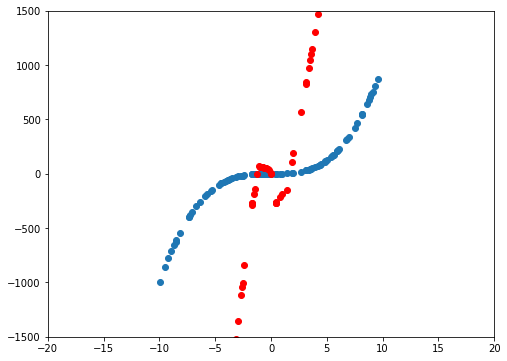

In [83]:
EPOCHS = 1500

# Store training stats
history_0 = model_0.fit(post_train_data_0, train_labels_0, epochs=EPOCHS,
                    validation_split=0.2, verbose=0)

predicted_0 = model_0.predict(train_data_0).reshape(data_points, 1)


plt.figure(figsize=(8,6))

plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_0, train_labels_0_pre)
plt.scatter(train_data_0, predicted_0, c='red')
plt.show()

### A uniform distribution with Guassian noise (0, 50)

In [137]:
train_data_1 = np.random.uniform(-10, 10, 100)

mu_train_1, sigma_train_1 = 0, 50
noise_train_1 = np.random.normal(mu_train_1, sigma_train_1, 100)

train_labels_1_pre = np.power(train_data_1, 3) + noise_train_1

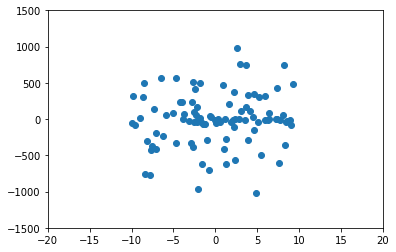

In [138]:
plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_1, train_labels_1)
plt.show()

In [141]:
order = np.argsort(np.random.random(train_labels_1.shape))

pre_train_data_1 = np.array(train_data_1[order]).reshape(100, 1)
train_labels_1 = np.array(train_labels_1_pre[order]).reshape(100, 1)

mean = pre_train_data_1.mean(axis=0)
std = pre_train_data_1.std(axis=0)

post_train_data_1 = (pre_train_data_1 - mean) / std

/Users/amirrahnama/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [142]:
model_1 = build_model(post_train_data_1)
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [143]:
EPOCHS = 500

# Store training stats
history_1 = model_1.fit(post_train_data_1, train_labels_1, epochs=EPOCHS,
                    validation_split=0.2, verbose=0)

In [30]:
predicted = model_1.predict(train_data_1).reshape(100, 1)

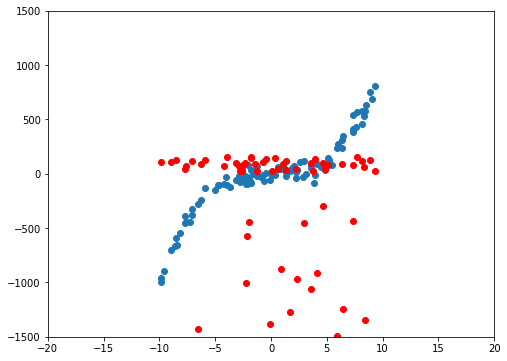

In [144]:
plt.figure(figsize=(8,6))

plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_1, train_labels_1_pre)
plt.scatter(train_data_1, predicted, c='red')
plt.show()


### Add more data to the same model

In [84]:
mu_train_2, sigma_train_2 = 0, 100

noise_train_2 = np.random.normal(mu_train_2, sigma_train_2, 100)
train_labels_2 = np.power(train_data_1, 3) + noise_train_2

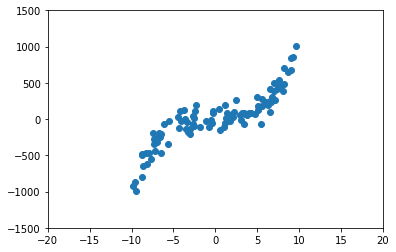

In [86]:
plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_1, train_labels_2)
plt.show()

In [87]:
order = np.argsort(np.random.random(train_labels_1.shape))
train_labels_2 = np.array(train_labels_2[order]).reshape(100, 1)

In [88]:
model_2 = build_model(post_train_data_1)
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [89]:
EPOCHS = 500

# Store training stats
history_2 = model_2.fit(post_train_data_1, train_labels_2, epochs=EPOCHS,
                    validation_split=0.2, verbose=0)

In [90]:
predicted_2 = model_2.predict(train_data_1).reshape(100, 1)

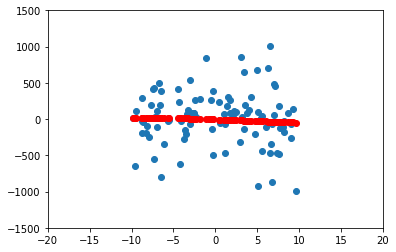

In [91]:
plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_1, train_labels_2)
plt.scatter(train_data_1, predicted_2, c='red')
plt.show()

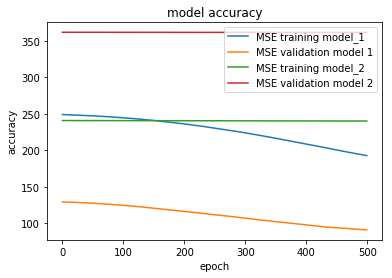

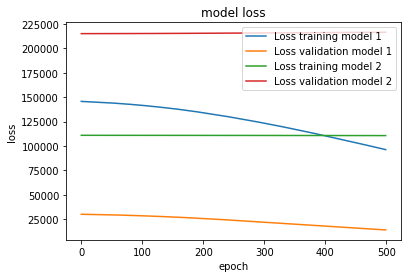

In [92]:
plt.plot(history_1.history['mean_absolute_error'], label= "MSE training model_1")
plt.plot(history_1.history['val_mean_absolute_error'], label= "MSE validation model 1")
plt.plot(history_2.history['mean_absolute_error'], label= "MSE training model_2")
plt.plot(history_2.history['val_mean_absolute_error'], label= "MSE validation model 2")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history_1.history['loss'], label="Loss training model 1")
plt.plot(history_1.history['val_loss'], label="Loss validation model 1")
plt.plot(history_2.history['loss'], label="Loss training model 2")
plt.plot(history_2.history['val_loss'], label="Loss validation model 2")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [93]:
np.mean(history_1.history['mean_absolute_error'])

227.212269732666

In [94]:
np.mean(history_2.history['mean_absolute_error'])

240.6719835479736

In [80]:
model_1.count_params()

193

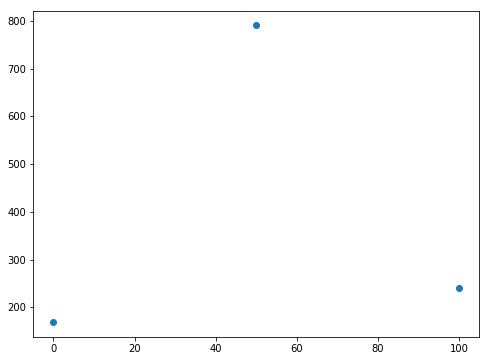

In [132]:
x = [np.mean(history_0.history['mean_absolute_error']), 
     np.mean(history_1.history['mean_absolute_error']), 
     np.mean(history_2.history['mean_absolute_error'])]

y = [sigma_train_0, sigma_train_1, sigma_train_2]

plt.figure(figsize=(8,6))

plt.scatter(y, x)
plt.show()